In [3]:
%matplotlib inline
import os
import re
import numpy as np
import pandas as pd
import scipy.ndimage as ndi
from skimage import measure, io
import matplotlib.pyplot as plt
import mahotas as mh
import matplotlib.mlab as mlab
import matplotlib.ticker as ticker

/home/ws/anka-bl-topo-to-0001/roman/ntbk/lib/python2.7/site-packages/matplotlib/__init__.py:913: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [40]:
def save_fig(fig, output_filepath, dpi=72, use_tl=True):
    output_path, filename = os.path.split(output_filepath)
        
    if not os.path.exists(output_path):
        os.makedirs(output_path)
    
    if use_tl:
        plt.tight_layout()
        
    fig.savefig(output_filepath, dpi=dpi)

In [5]:
def number(val):
    if val < 1000:
        return '%d' % val
        
    sv = str(val)
    return '$\mathregular{10^{%d}}$' % (len(sv)-2) if val % 10 == 0 else '%0.0e' % val

In [6]:
def get_data_by_type(path, type, unit_scale=5.5):
    if type == 'p':
        data = pd.read_csv(path)['area'] * (unit_scale**3)
    elif type == 'd':
        data = np.load(path).item()
        data = data['diameter']
        data = data * unit_scale * 2
    else:
        return None
    
    return data

In [7]:
def get_result_path(sample_name, input_dir, data_folder_name, type='p'):
    if type == 'p':
        return os.path.join(input_dir, sample_name, data_folder_name, 'particles.csv'.format(sample_name=sample_name))
    else:
        return None

In [8]:
COLORS = {
    'blue':   ['#077ca7', '#11a5cb', '#42c3d9', '#85d7e2', '#a4e1e4', '#dff4f5'], \
    'green':  ['#447a6d', '#6ea393', '#93c3b3', '#b8daca', '#dceee2', '#ecf4ee'], \
    'violet': ['#6c569e', '#9c84c0', '#cebce2', '#dacade', '#e3d6e6', '#f3e9f2'], \
    'red':    ['#b64b77', '#d07297', '#e492b6', '#f2b8ce', '#fadadf', '#fce8eb']
}

In [9]:
def create_pie_chart(sample_name, input_dir, rngs, data_folder_name='particles_stats', title=None, \
                     type='p', unit_scale=5.5, color_name=None):
    dpy_path = get_result_path(sample_name, input_dir, data_folder_name, type=type)
    df = get_data_by_type(dpy_path, type=type, unit_scale=unit_scale)
    
    print 'Max: {}, Min: {}'.format(df.max(), df.min())
    
    data_ranges = []
    for rng in rngs:
        rng_min, rng_max = rng[0], rng[1]
        data_rng = df[(df > rng_min) & (df < rng_max)]
        data_ranges.append(data_rng)
    
    num_elem = [len(p) for p in data_ranges]
    se = sum(num_elem)

    proc_particles = [n/float(se) * 100.0 for n in num_elem]      
                      
    def get_title(v1, v2):
        return '%s $\minus$ %s $\mathregular{\mu m^3}$' % (number(v1), number(v2))
                      
    titles = [get_title(minv, maxv) for minv,maxv in rngs]
    
    #colors = ['#1E824C', '#80B584', '#A6CAA9', '#C9DECB', '#E9F1EA'] #green
    #colors = ['#663399', '#AD8BFE', '#C4ABFE', '#BE90D4', '#DDCEFF'] #purple
    #colors = ['#ae4900', '#c75400', '#e15e00', '#ff862e', '#ff862e'] #orange
    
    if color_name is None:
        colors = ['#23819C', '#2FAACE', '#57BCD9', '#8CD1E6', '#B8E2EF', '#c4f1ff'] #blue
    else:
        colors = COLORS[color_name] 

    textprops={'fontsize': 55, 'weight': 'normal', 'family': 'sans-serif'}
    pie_width = 0.5
    fig, ax = plt.subplots(figsize=(33,15))
    ax.axis('equal')
    patches, texts, autotexts = ax.pie(proc_particles, \
                                       textprops=textprops, \
                                       colors=colors, \
                                       autopct='%1.1f%%', \
                                       radius=1, \
                                       pctdistance=1-pie_width/2)
    
    plt.setp(patches, \
             width=pie_width, \
             edgecolor='white')
    
#     if title is not None:
#         plt.text(0.5, 0.5, \
#                  title, \
#                  horizontalalignment='center', \
#                  verticalalignment='center', \
#                  weight='bold', \
#                  fontsize=80, \
#                  transform=ax.transAxes)
    
   
    
    plt.legend(patches, titles, loc=(0.755,0.5), fontsize=50)
    
    _d, _offset, _di = [1,-1], [0.45, 0.45], 0
    
    for t, p in zip(autotexts, proc_particles):
        if p < 2.0:
            pos = list(t.get_position())
            pos[0] = pos[0] + _d[_di] * _offset[_di]

            t.set_position(pos)
            _di += 1
            
    #plt.show()
    
    #ax.pie(proc_particles, labels=titles, autopct='%d%%', startangle=270)
    #plt.axis('equal')
              
    #series = pd.Series(np.array(proc_particles), index=titles)
    #ax = series.plot.pie(figsize=(6, 6), radius=1, pctdistance=1-width/2, legend=True)
    #plt.show()
    #plt.subplots_adjust(left=-0.9, right=1, top=1, bottom=-0.08)
    #plt.tight_layout()
    save_fig(fig, os.path.join(input_dir, sample_name, data_folder_name, '_'.join([sample_name, title, 'pie', ]) + '.png'))

# Samples
## Zd - PS
## Zn - Zn
## Sn - Sr
## Mg - Mg

# ROI (350x350x350)

Max: 209853279.625, Min: 166.375


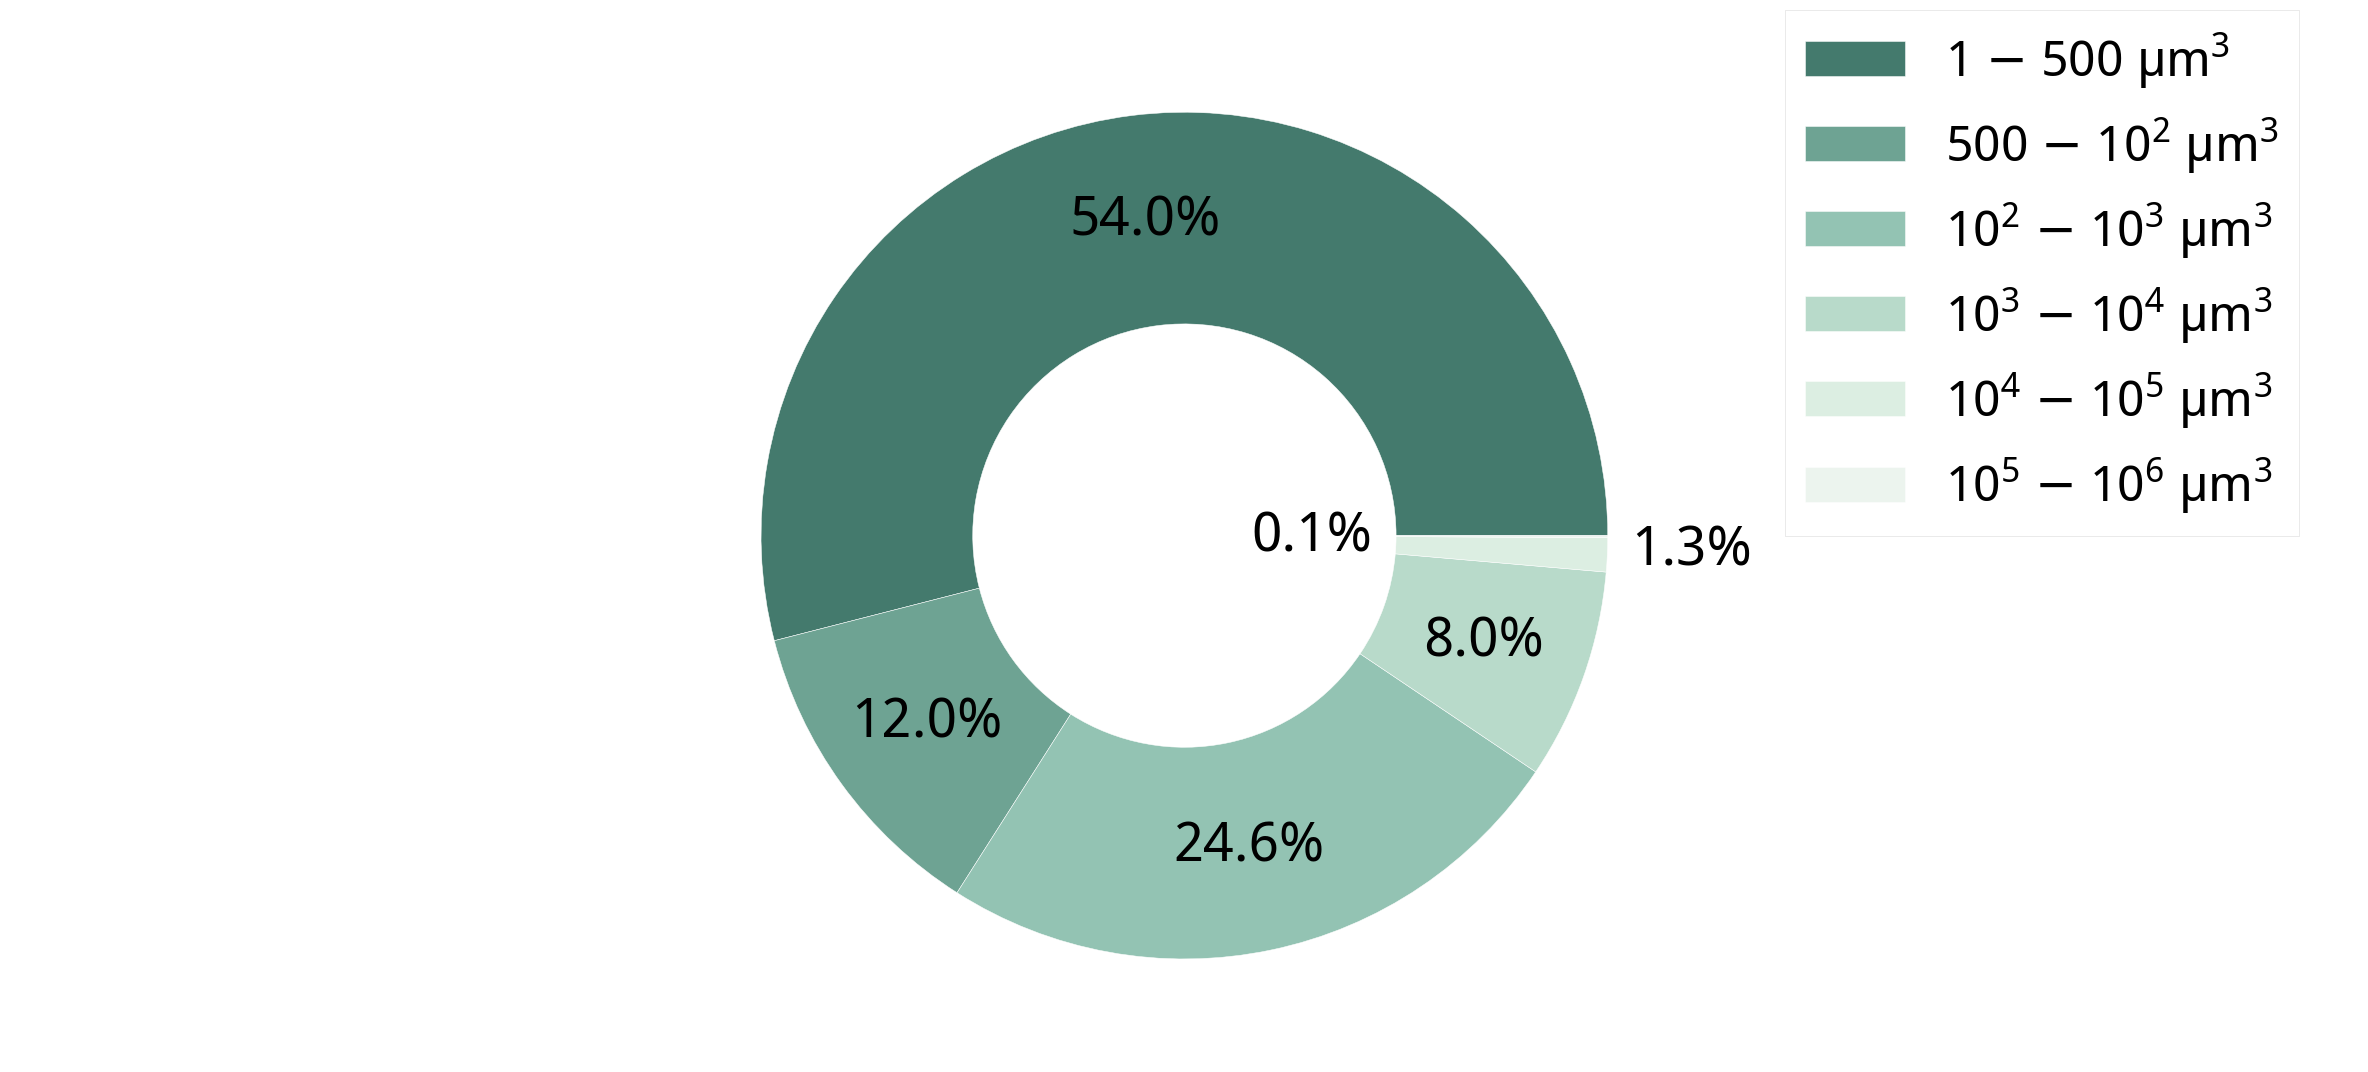

In [11]:
create_pie_chart('Zd_40fps_Silicon', \
                 './data/bioglass_results/', \
                 [(1,500), (500, 1000), (1000,10000), (10000,100000), (100000,1000000), (1000000,10000000)], \
                 data_folder_name='particles_stats', \
                 title='Zd', \
                 type='p', \
                 color_name='green')

Max: 37186309.875, Min: 166.375


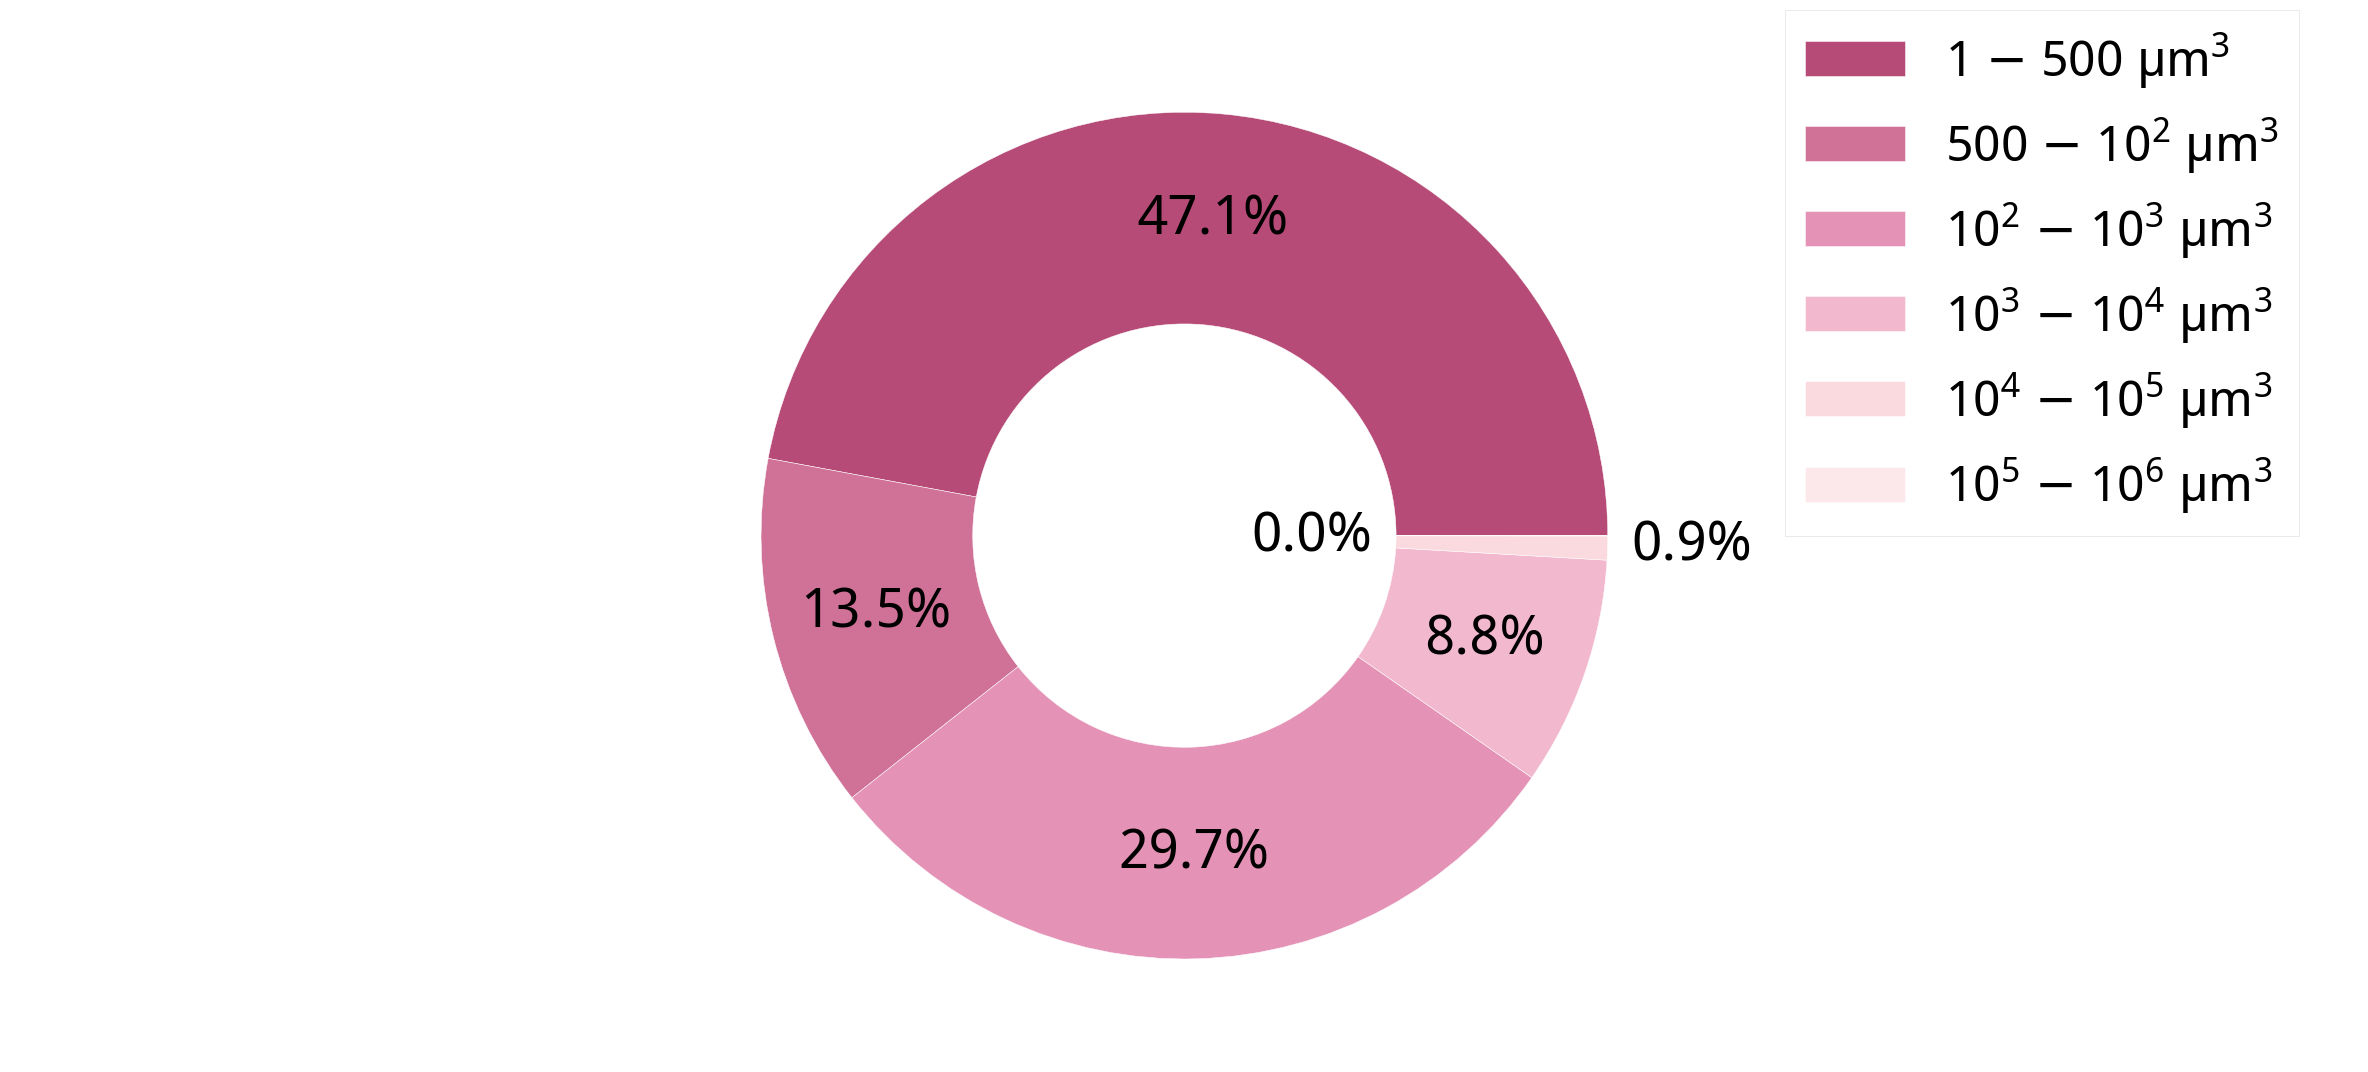

In [12]:
create_pie_chart('Zn_40fps_Silicon', \
                 './data/bioglass_results/', \
                 [(1,500), (500, 1000), (1000,10000), (10000,100000), (100000,1000000), (1000000,10000000)], \
                 data_folder_name='particles_stats', \
                 title='Zn', \
                 type='p', \
                 color_name='red')

Max: 115372078.25, Min: 166.375


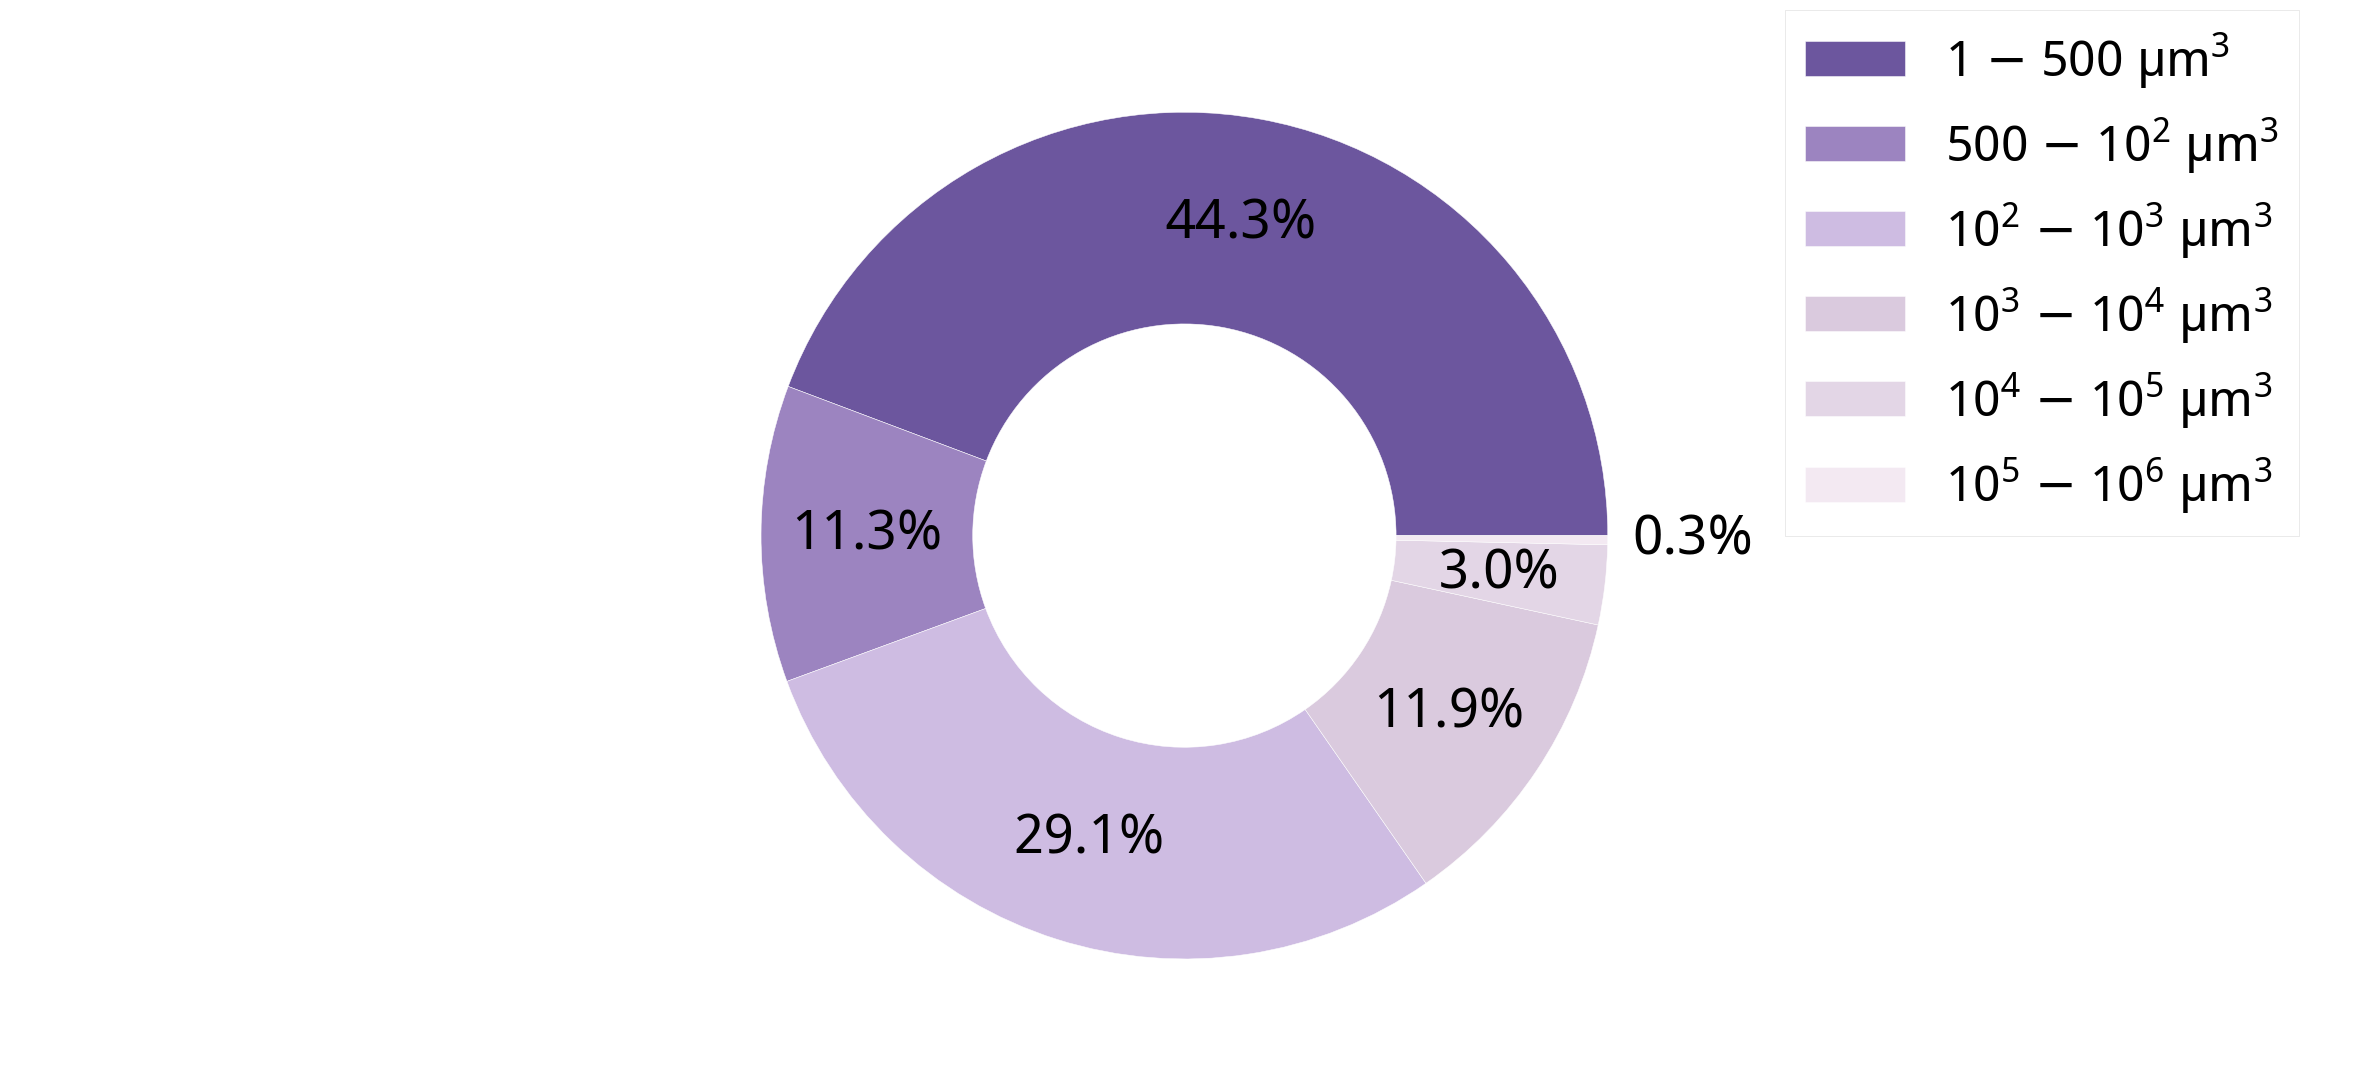

In [13]:
create_pie_chart('Sn_40fps_Silicon', \
                 './data/bioglass_results/', \
                 [(1,500), (500, 1000), (1000,10000), (10000,100000), (100000,1000000), (1000000,10000000)], \
                 data_folder_name='particles_stats', \
                 title='Sn', \
                 type='p', \
                 color_name='violet')

Max: 754927061.625, Min: 166.375


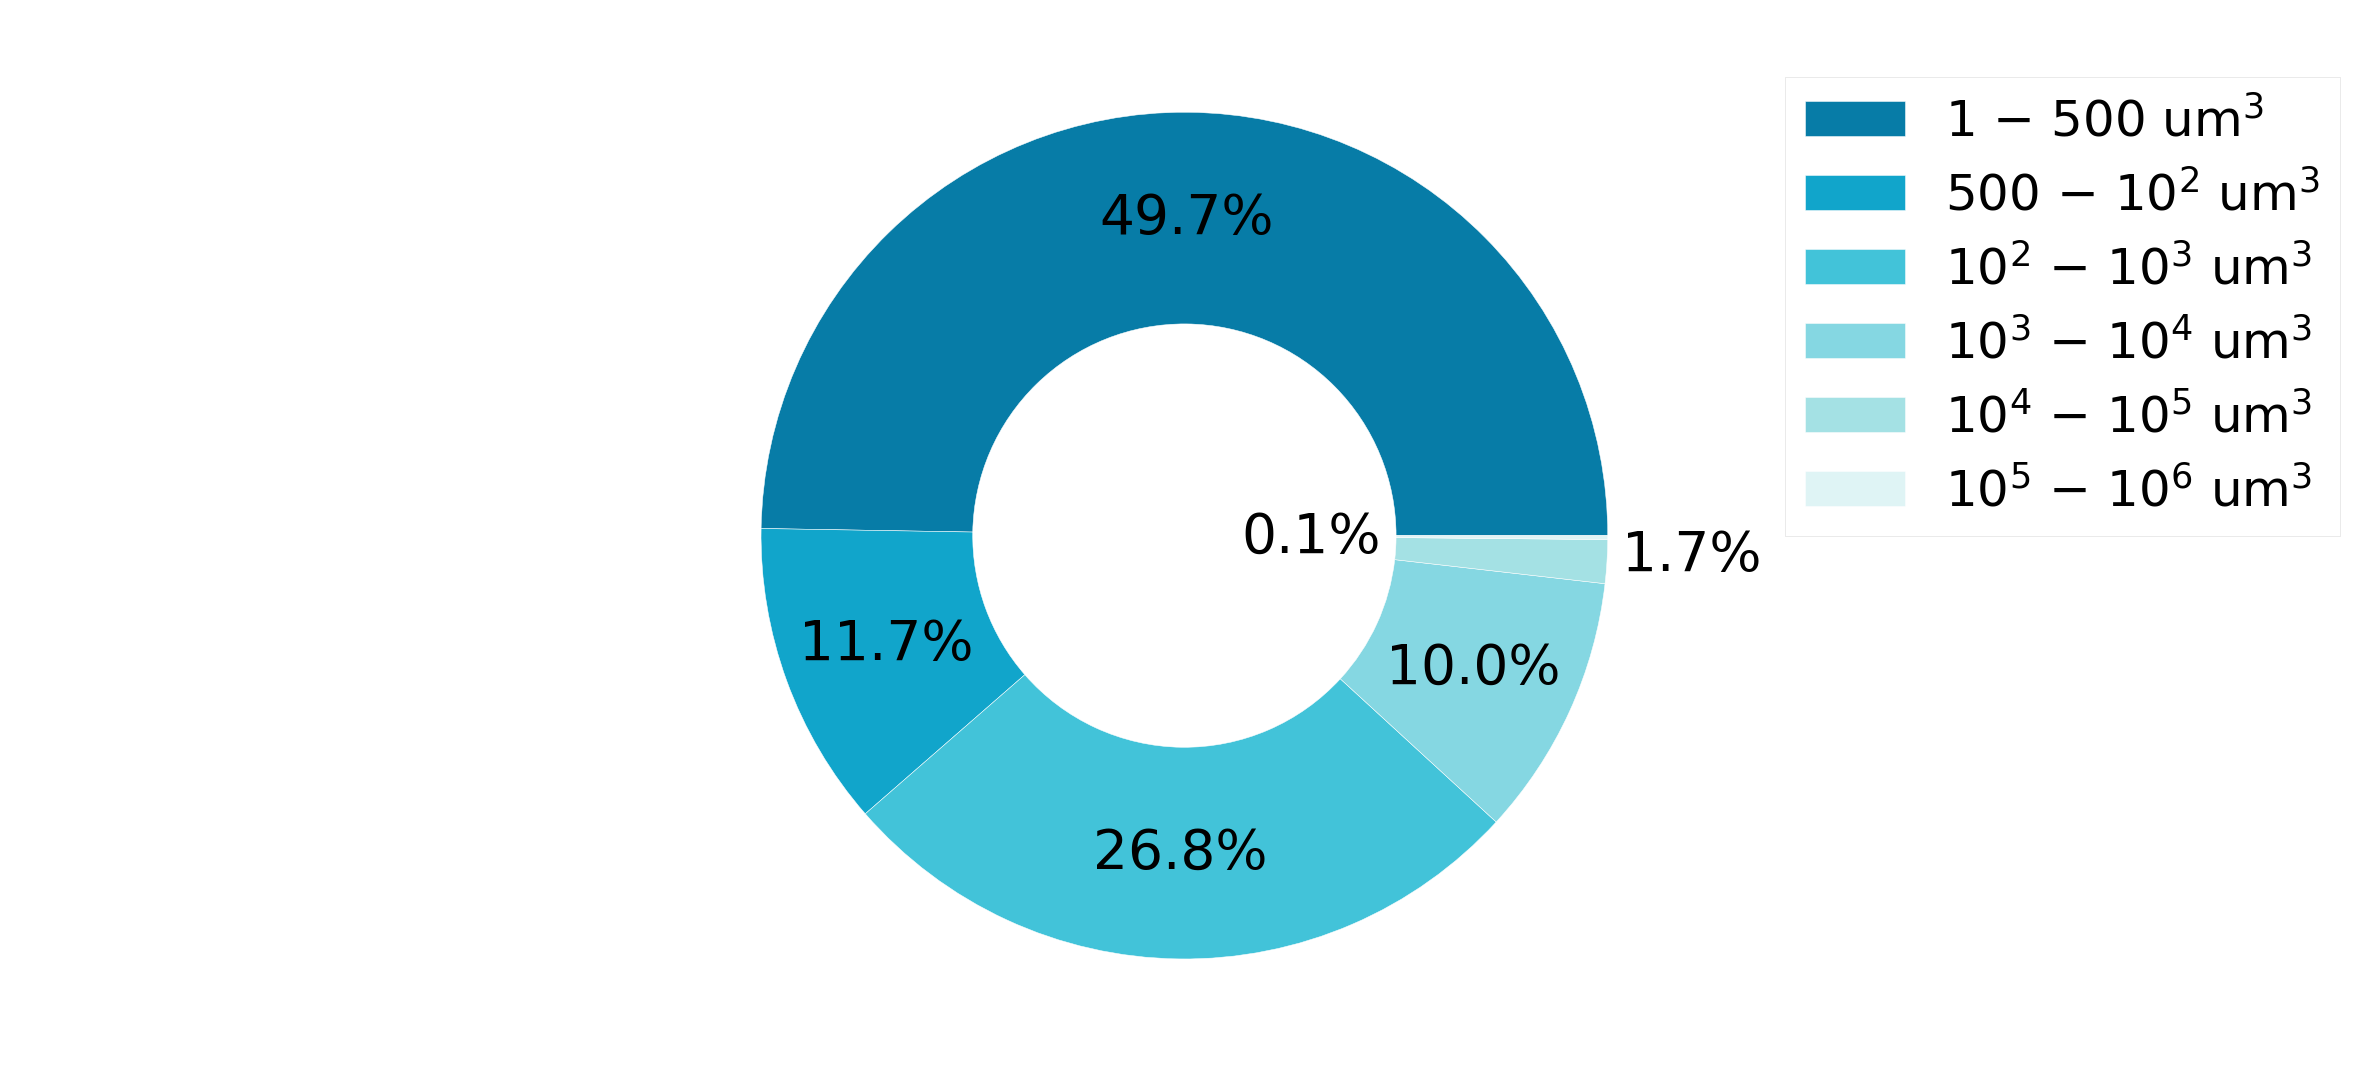

In [106]:
create_pie_chart('Mg_40fps_Silicon', \
                 './data/bioglass_results/', \
                 [(1,500), (500, 1000), (1000,10000), (10000,100000), (100000,1000000), (1000000,10000000)], \
                 data_folder_name='particles_stats', \
                 title='Mg', \
                 type='p', \
                 color_name='blue')

# ROI (500x500x500)

Max: 439267268.0, Min: 166.375


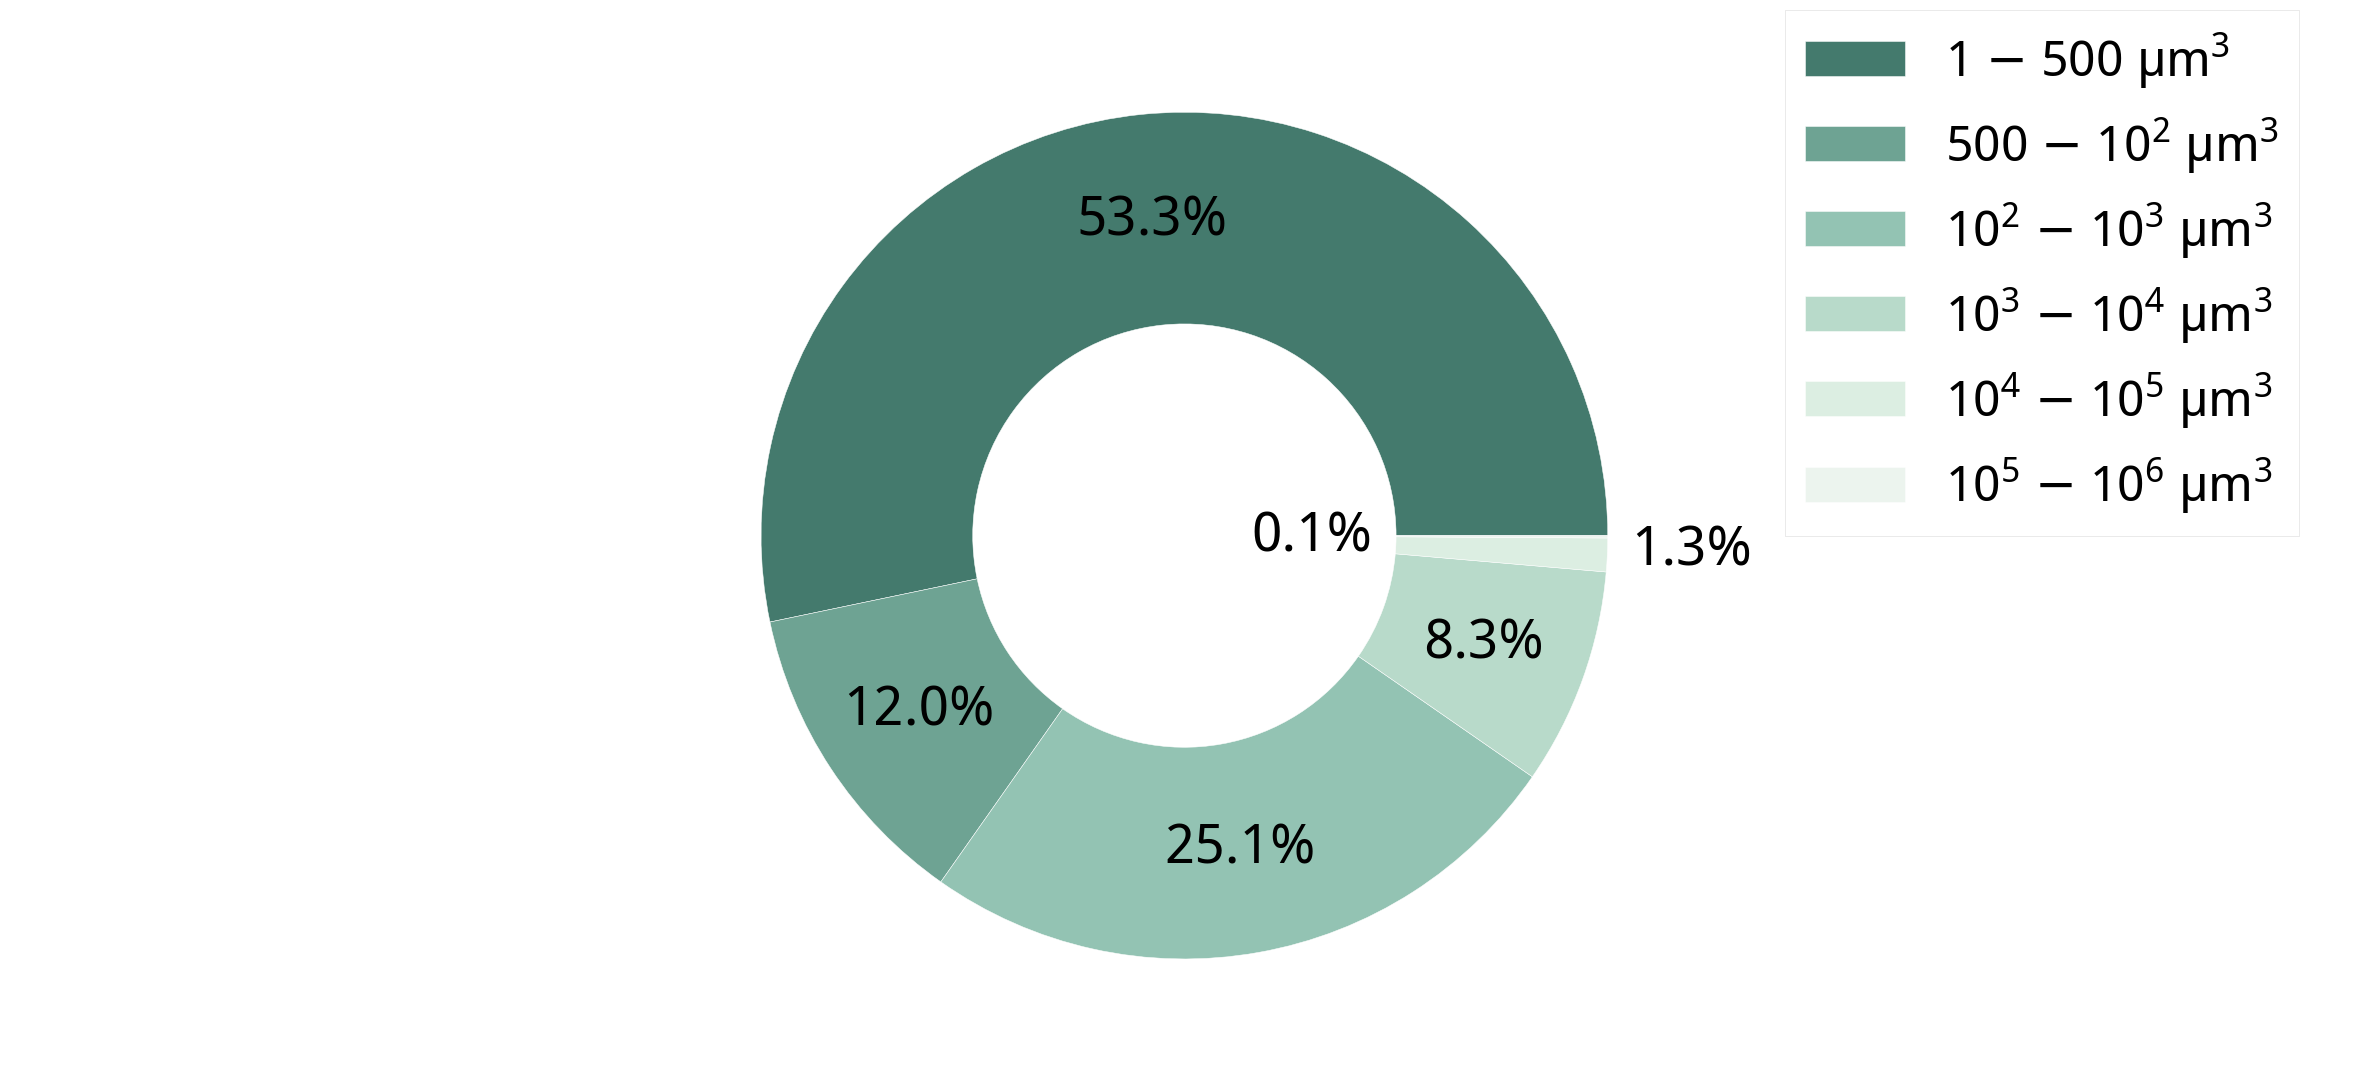

In [14]:
create_pie_chart('Zd_40fps_Silicon', './data/bioglass_results/', \
                 [(1,500), (500, 1000), (1000,10000), (10000,100000), (100000,1000000), (1000000,10000000)], \
                 data_folder_name='particles_stats_500', \
                 title='Zd', \
                 type='p', \
                 color_name='green')

Max: 127410640.5, Min: 166.375


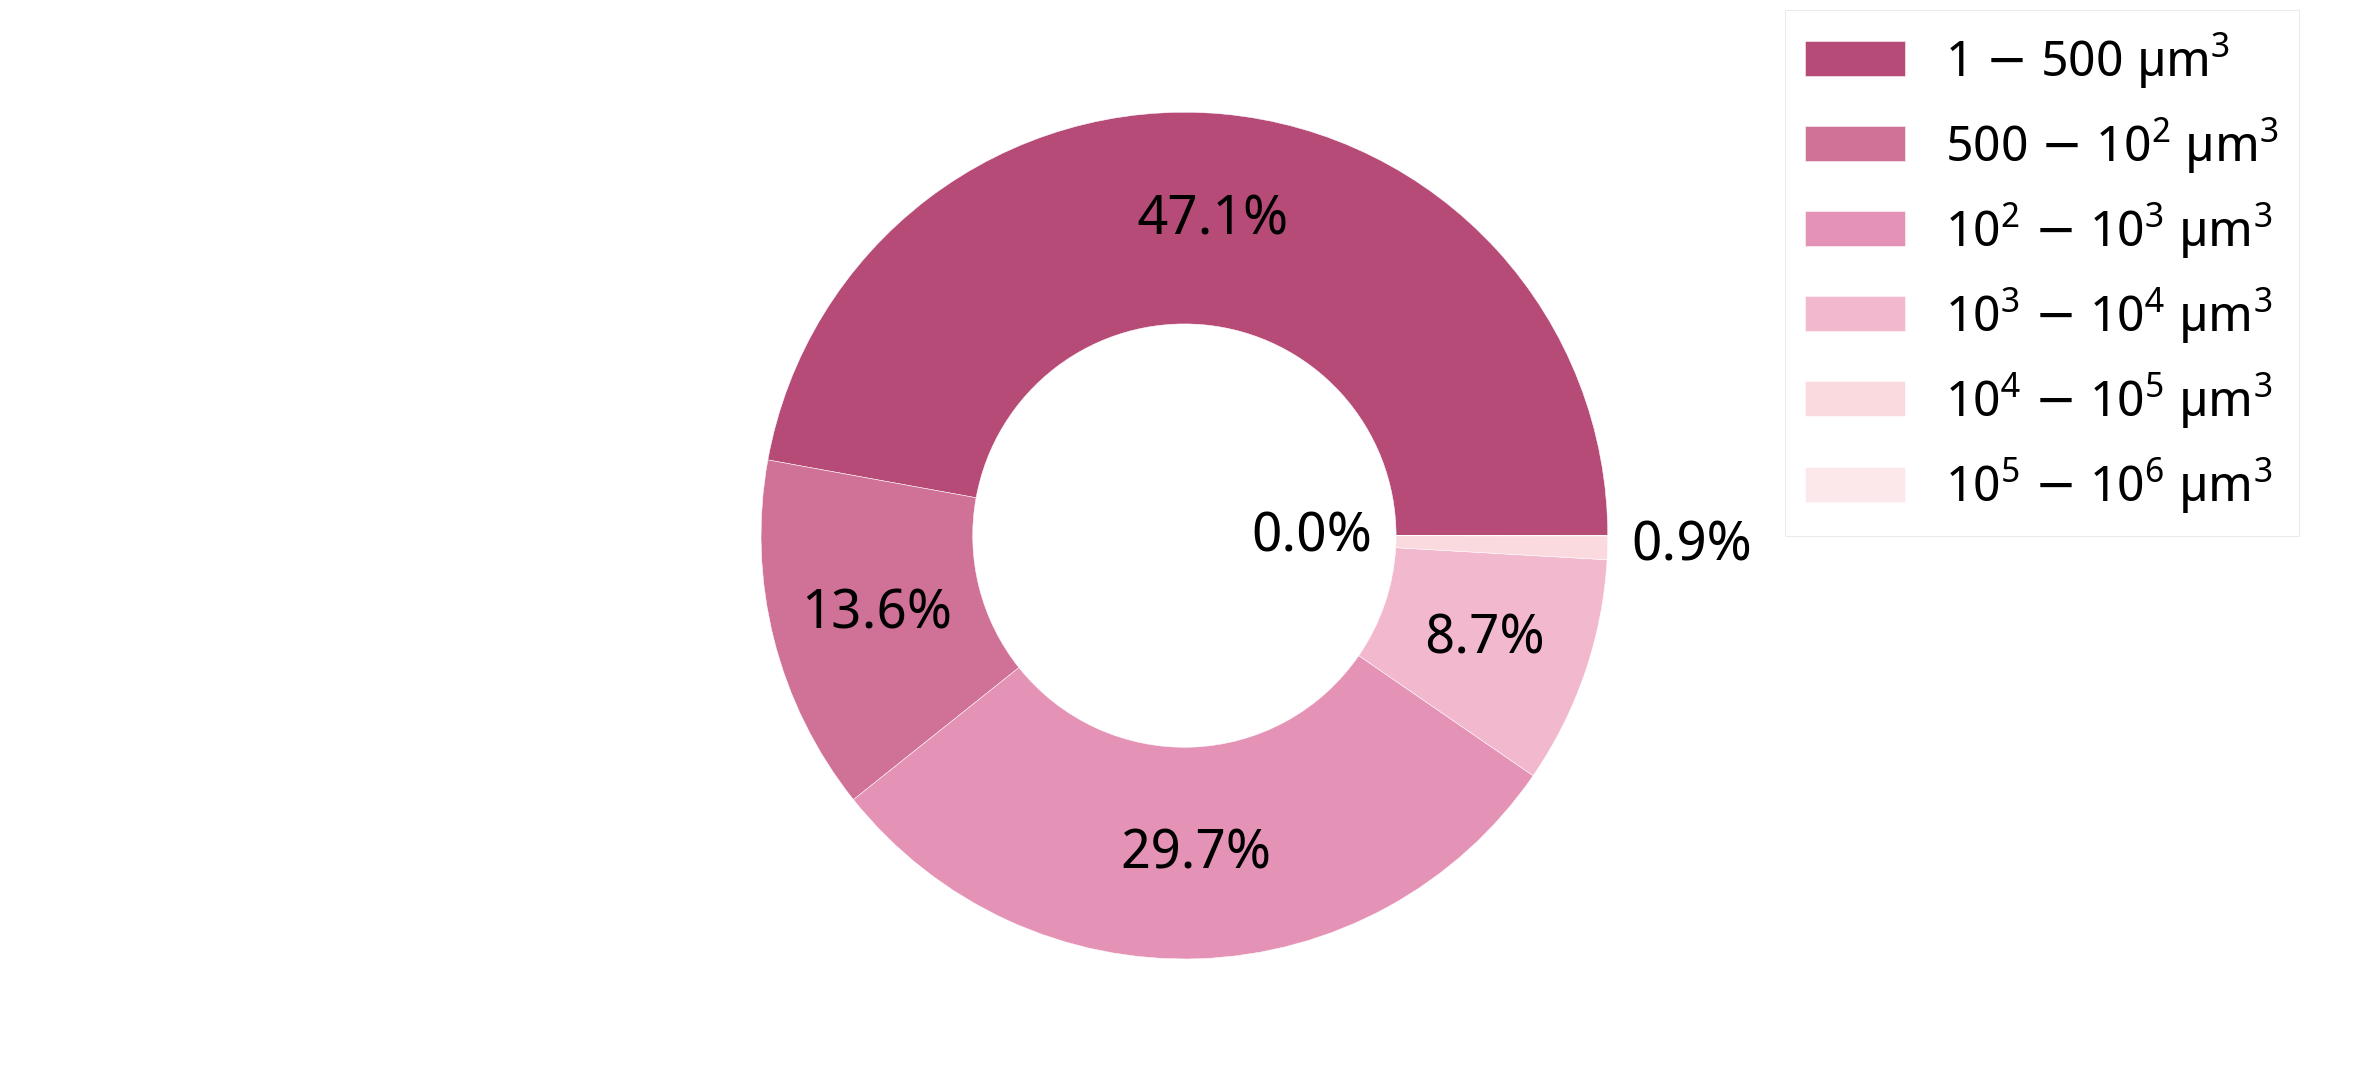

In [15]:
create_pie_chart('Zn_40fps_Silicon', './data/bioglass_results/', \
                 [(1,500), (500, 1000), (1000,10000), (10000,100000), (100000,1000000), (1000000,10000000)], \
                 data_folder_name='particles_stats_500', \
                 title='Zn', \
                 type='p', \
                 color_name='red')

Max: 248841098.0, Min: 166.375


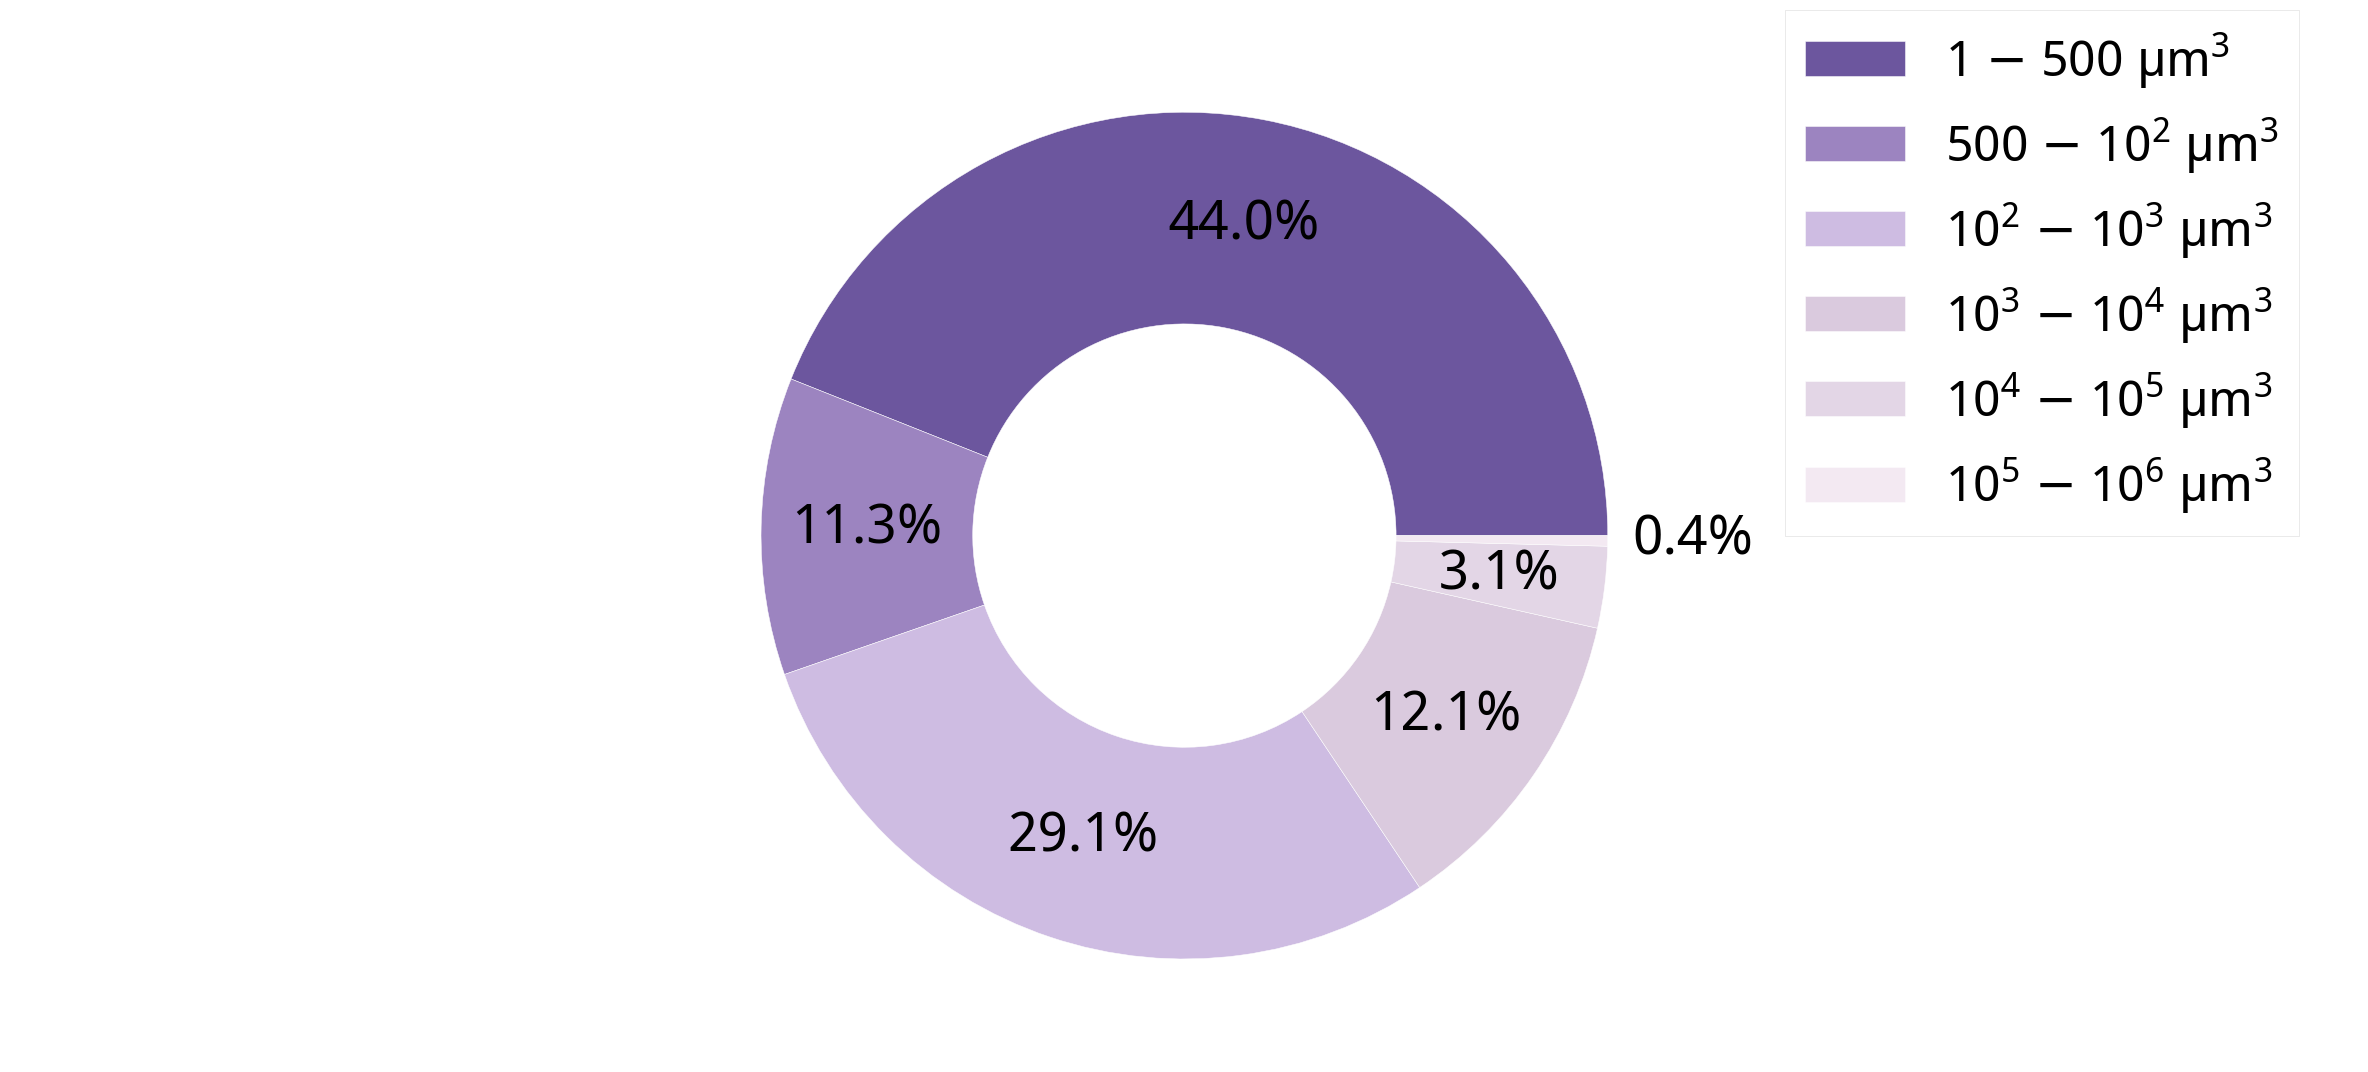

In [16]:
create_pie_chart('Sn_40fps_Silicon', './data/bioglass_results/', \
                 [(1,500), (500, 1000), (1000,10000), (10000,100000), (100000,1000000), (1000000,10000000)], \
                 data_folder_name='particles_stats_500', \
                 title='Sn', \
                 type='p', \
                 color_name='violet')

Max: 2275010419.0, Min: 166.375


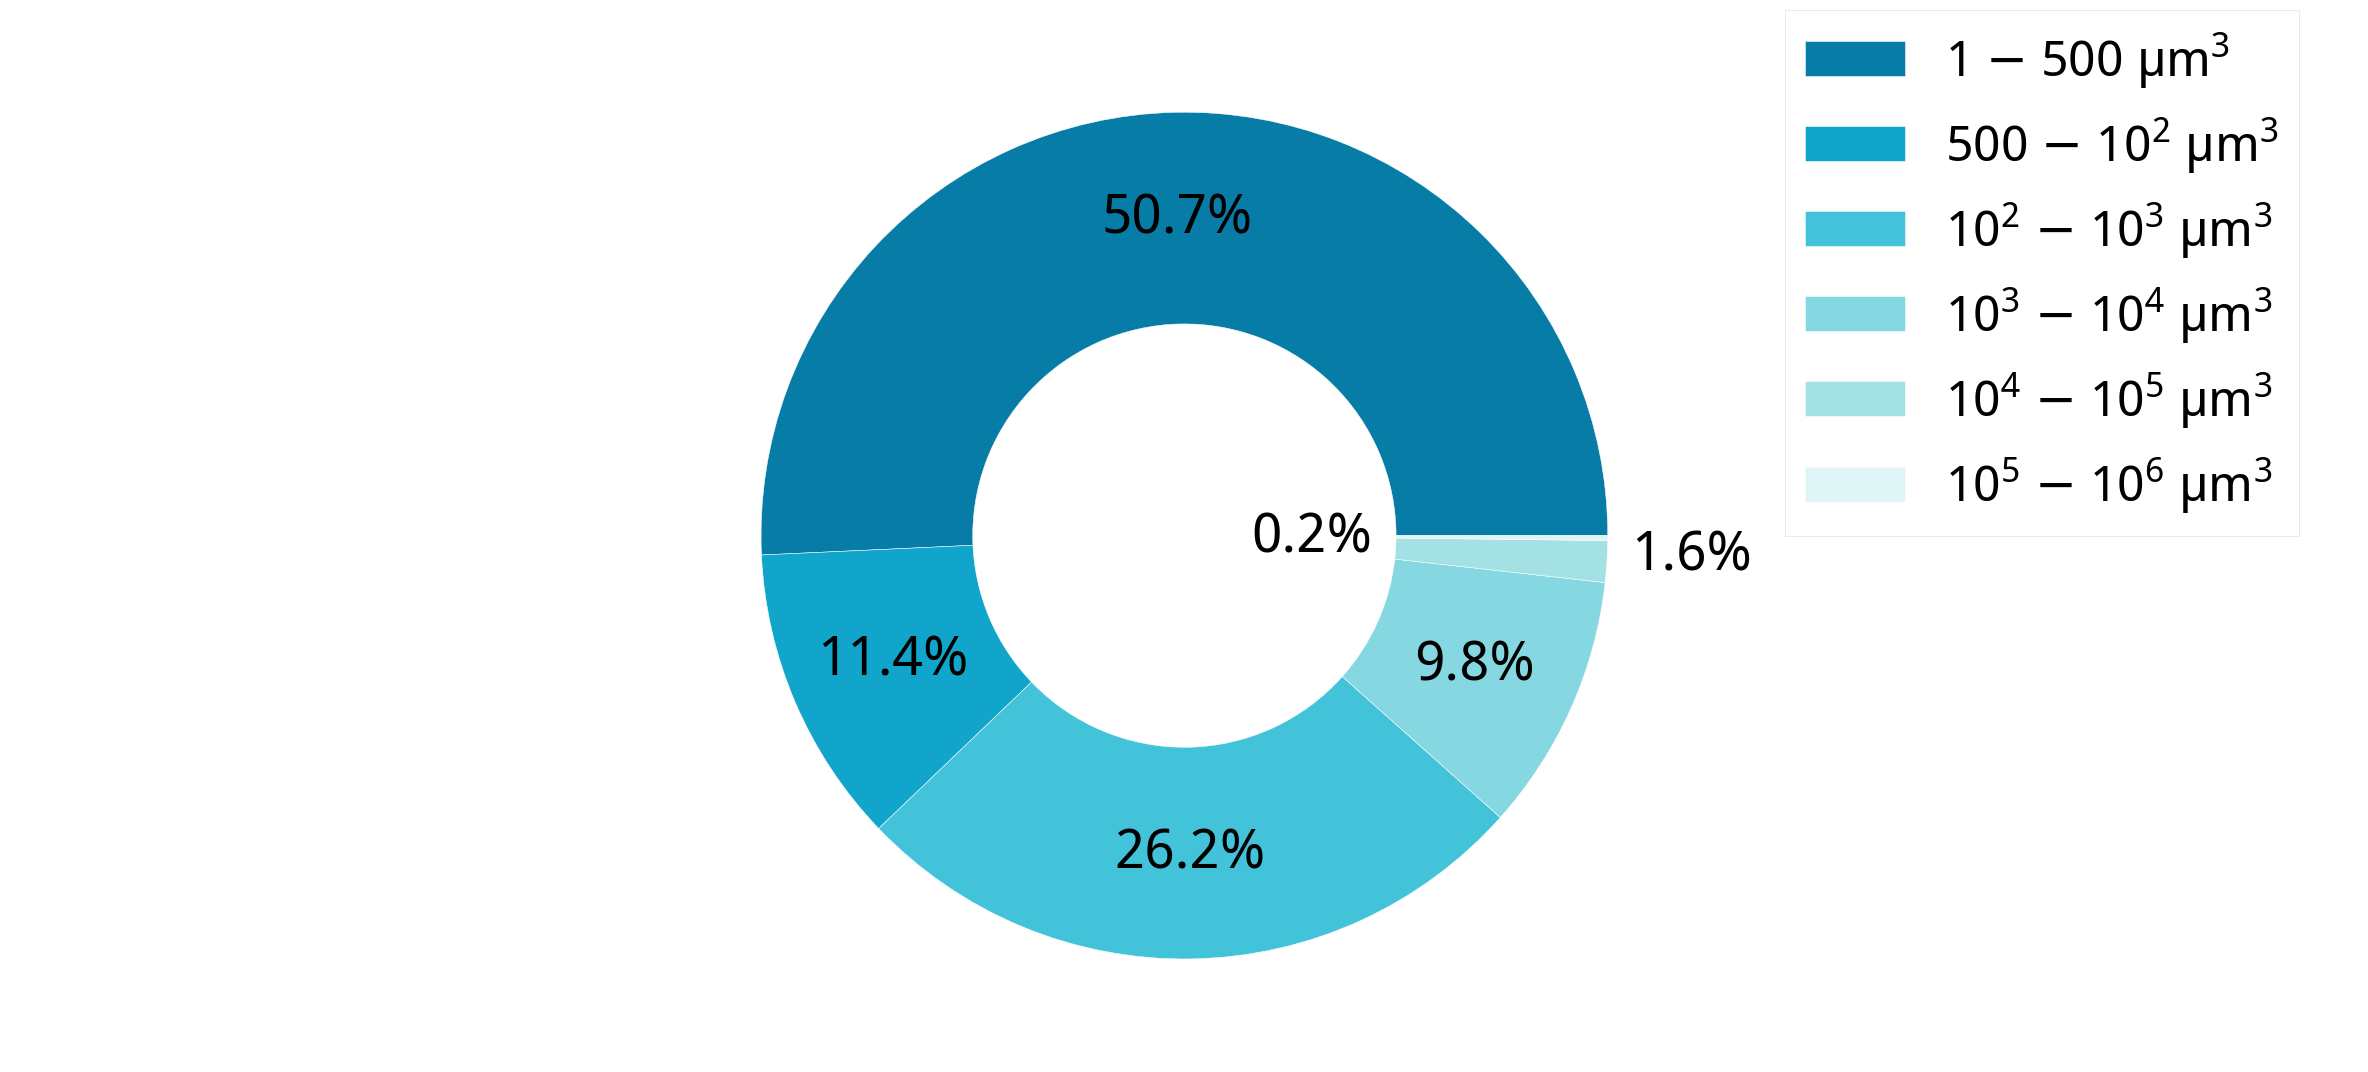

In [17]:
create_pie_chart('Mg_40fps_Silicon', './data/bioglass_results/', \
                 [(1,500), (500, 1000), (1000,10000), (10000,100000), (100000,1000000), (1000000,10000000)], \
                 data_folder_name='particles_stats_500', \
                 title='Mg', \
                 type='p', \
                 color_name='blue')

# Histograms

In [69]:
def plot_barchart(input_path, 
                  output_path, 
                  sample_name,
                  ranges,
                  color_name,
                  stat_folder='particles_stats_500',
                  stats_filename='particles.csv',
                  print_log=True,
                  plot_rects=False, 
                  ps3=5.5**3):
    from matplotlib.patches import Rectangle
    from matplotlib.transforms import Bbox
    from matplotlib.ticker import MaxNLocator
    
    data_frames = []
    
    color = COLORS[color_name][0]
    
    def _plot_chart(df, rng, fontsize, color, figsize=(15,12)):       
        fig, ax = plt.subplots(figsize=figsize)

        ax.margins(x=0.05, y=0.1)
        ax.hist(df.values, 
                bins=50, 
                color=color, 
                edgecolor='#000000',
                linewidth=1.5)
        
        ax.set_position(Bbox.from_bounds(0.05, 0.05, 0.95, 0.95))
        
        ax.set_xlim((rng[0], rng[1]))
        
        ax.tick_params(axis='x', labelsize=fontsize, colors='#000000', 
                       which='both', direction='out', length=8, width=2)
        ax.tick_params(axis='x', labelsize=fontsize, colors='#000000', 
                       which='minor', direction='out', length=8, width=2)
        
        ax.tick_params(axis='y', labelsize=fontsize, colors='#000000', 
                       which='major', direction='out', length=8, width=2)
        ax.tick_params(axis='y', labelsize=fontsize, colors='#000000', 
                       which='minor', direction='out', length=8, width=2)
        
        ax.set_xlabel(r'Size of particles, $\mathregular{\mu m^3}$', fontsize=fontsize, color='#000000')
        ax.set_ylabel('Number of particles', fontsize=fontsize, color='#000000')
        
        ax.yaxis.label.set_color('#000000')
        ax.xaxis.label.set_color('#000000')
        
        ax.xaxis.set_major_locator(MaxNLocator(prune='lower'))
        
        for k in ax.spines.keys():
            ax.spines[k].set_color('#000000')
            ax.spines[k].set_linewidth(2)
        
        ax.xaxis.offsetText.set_fontsize(fontsize)
        ax.yaxis.offsetText.set_fontsize(fontsize)
        
        exp_lbl = ax.yaxis.get_offset_text()
        exp_lbl.set_y(exp_lbl.get_position()[1] + 0.05)
        
        plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
        plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))

        return fig, ax
    
    fontsize = 45
    
    smpl_fmt = 'bar_plot_{}_{}_rect.png' if plot_rects else 'bar_plot_{}_{}.png'
    smpl_log_fmt = 'bar_plot_{}_{}_log_rect.png' if print_log else 'bar_plot_{}_{}_log.png'

    df_scan = pd.DataFrame.from_csv(os.path.join(input_path, sample_name, stat_folder, stats_filename))
    df_scan['volume(um^3)'] = df_scan['area'] * ps3

    for rng in ranges:
        data_frames.append(df_scan[(df_scan['volume(um^3)'] > rng[0]) & (df_scan['volume(um^3)'] < rng[1])]['volume(um^3)'])

    if print_log:
        fig, ax = _plot_chart(data_frames[0], ranges[0], fontsize, color, figsize=(25,12))
        ax.set_yscale('log')
        
        plt.show()
        fig.savefig(os.path.join(output_path, sample_name, smpl_log_fmt.format(ranges[0][0], ranges[0][1])),
                    transparent=False, 
                    bbox_inches='tight', 
                    pad_inches=0.1)    
        
        
    fig, ax = _plot_chart(data_frames[0], ranges[0], fontsize, color, figsize=(25,12))
    
    if plot_rects:
        hsit_val_max = np.max(np.histogram(data_frames[0].values, bins=50)[0])
        cclrs = ['red', 'green', 'blue', 'magenta', 'yellowgreen']
        
        for i,(c, r) in enumerate(zip(cclrs, ranges[1:])):
            if i == (len(ranges[1:]) - 1):
                ax.add_patch(Rectangle((r[0],0), r[1]-r[0], hsit_val_max, linewidth=1.5, edgecolor=c, facecolor='none'))
            else:
                ax.add_patch(Rectangle((r[0],0), r[1]-r[0], hsit_val_max, linewidth=1.5, edgecolor=c, facecolor='none'))

    plt.show()
    fig.savefig(os.path.join(output_path, sample_name, smpl_fmt.format(ranges[0][0], ranges[0][1])),
                    transparent=False, 
                    bbox_inches='tight', 
                    pad_inches=0.1)
            
    for df, rng in zip(data_frames[1:], ranges[1:]):
        fig, ax = _plot_chart(df, rng, fontsize, color)

        plt.show()  
        fig.savefig(os.path.join(output_path, sample_name, smpl_fmt.format(rng[0], rng[1])),
                    transparent=False, 
                    bbox_inches='tight', 
                    pad_inches=0.1)

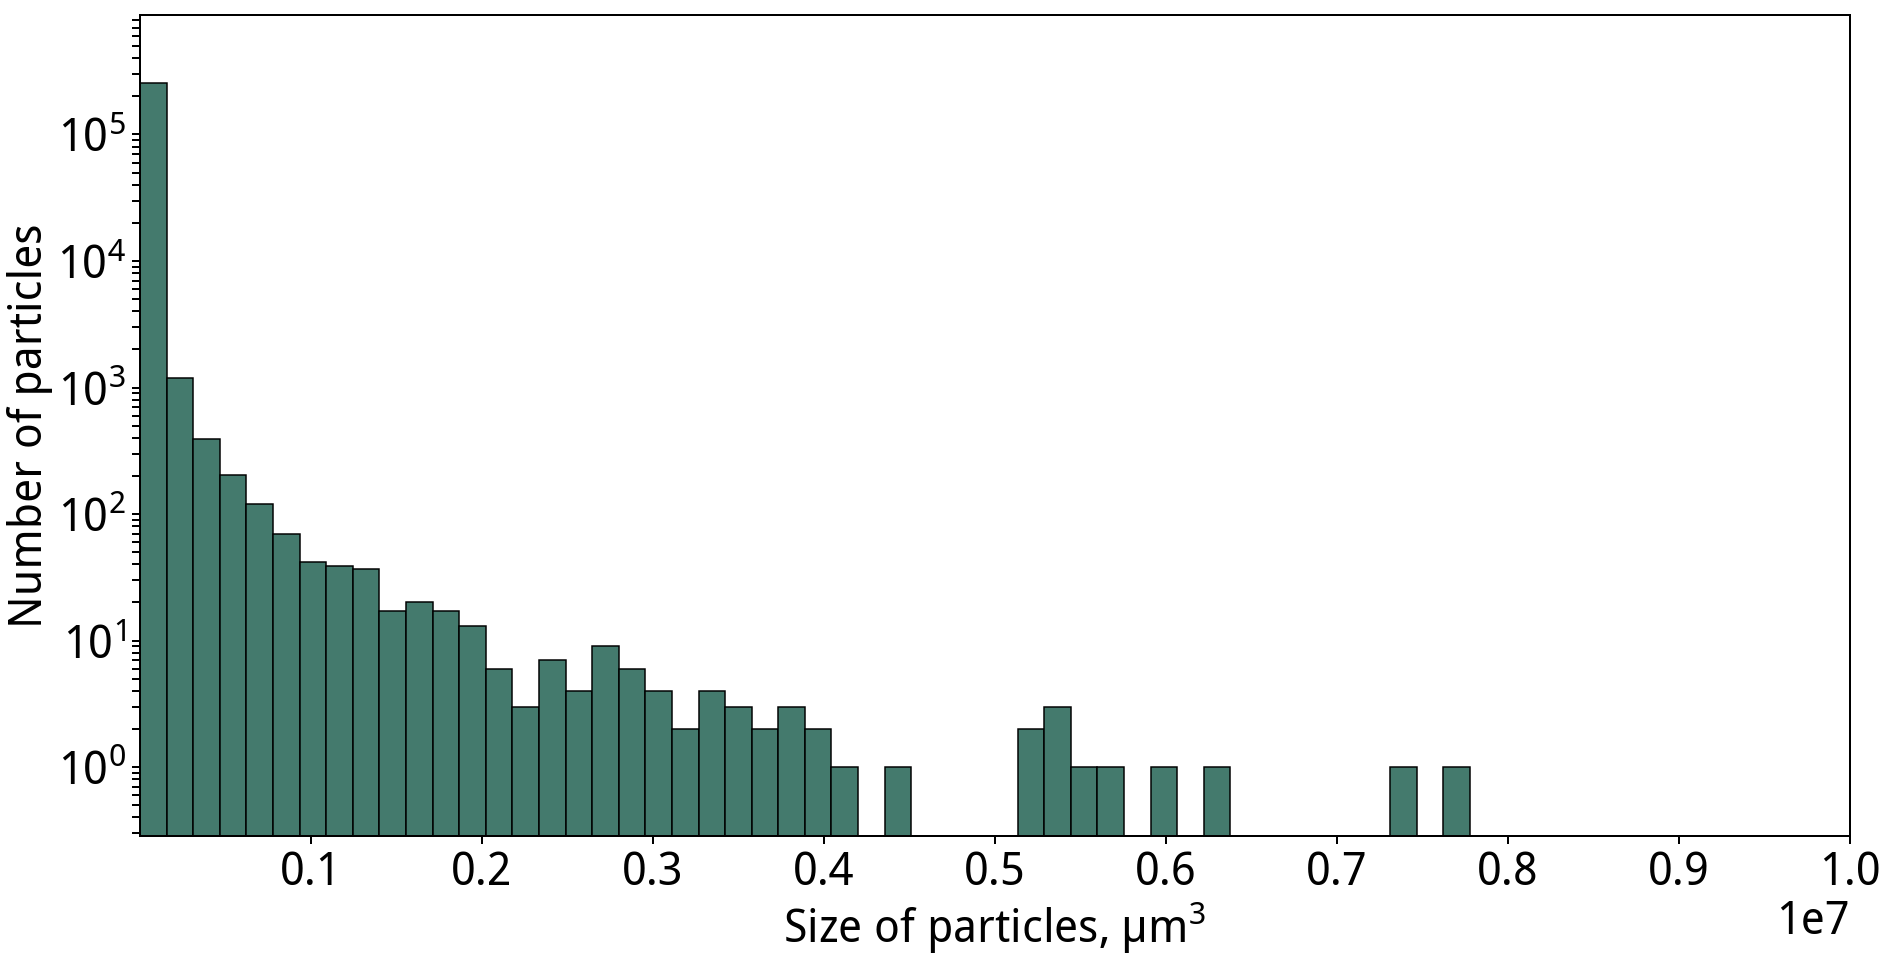

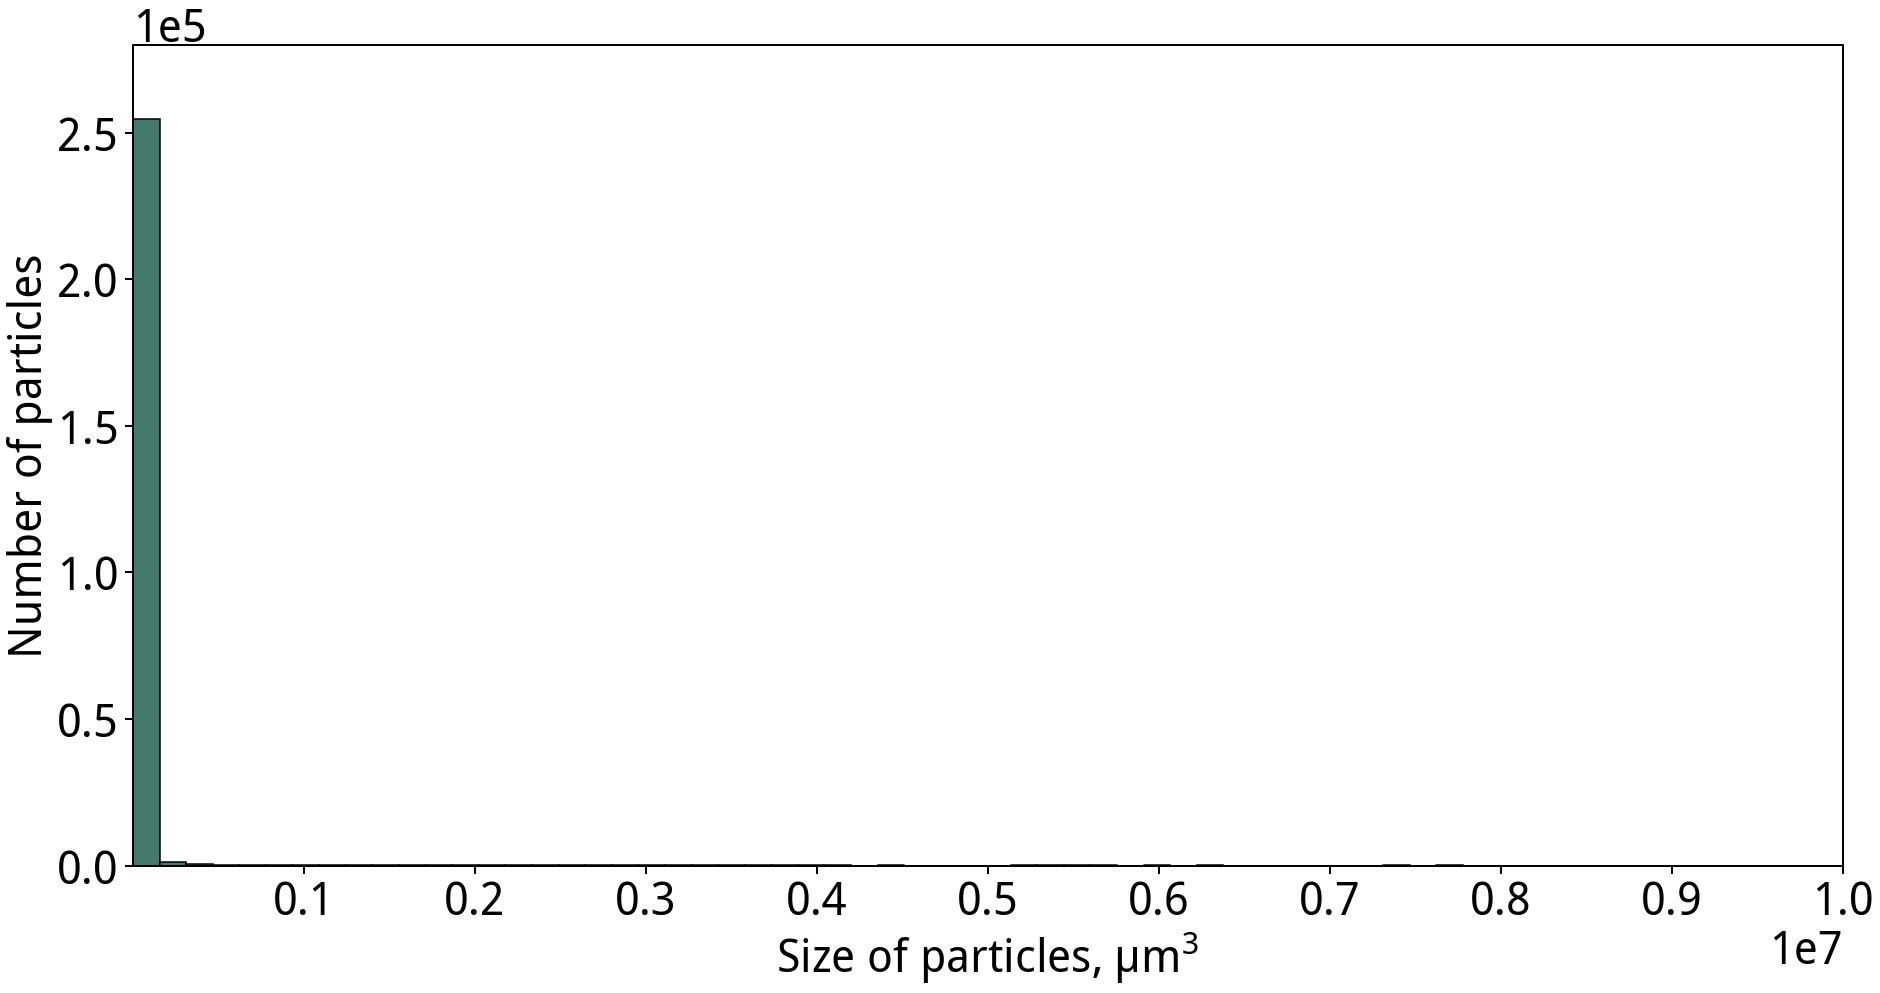

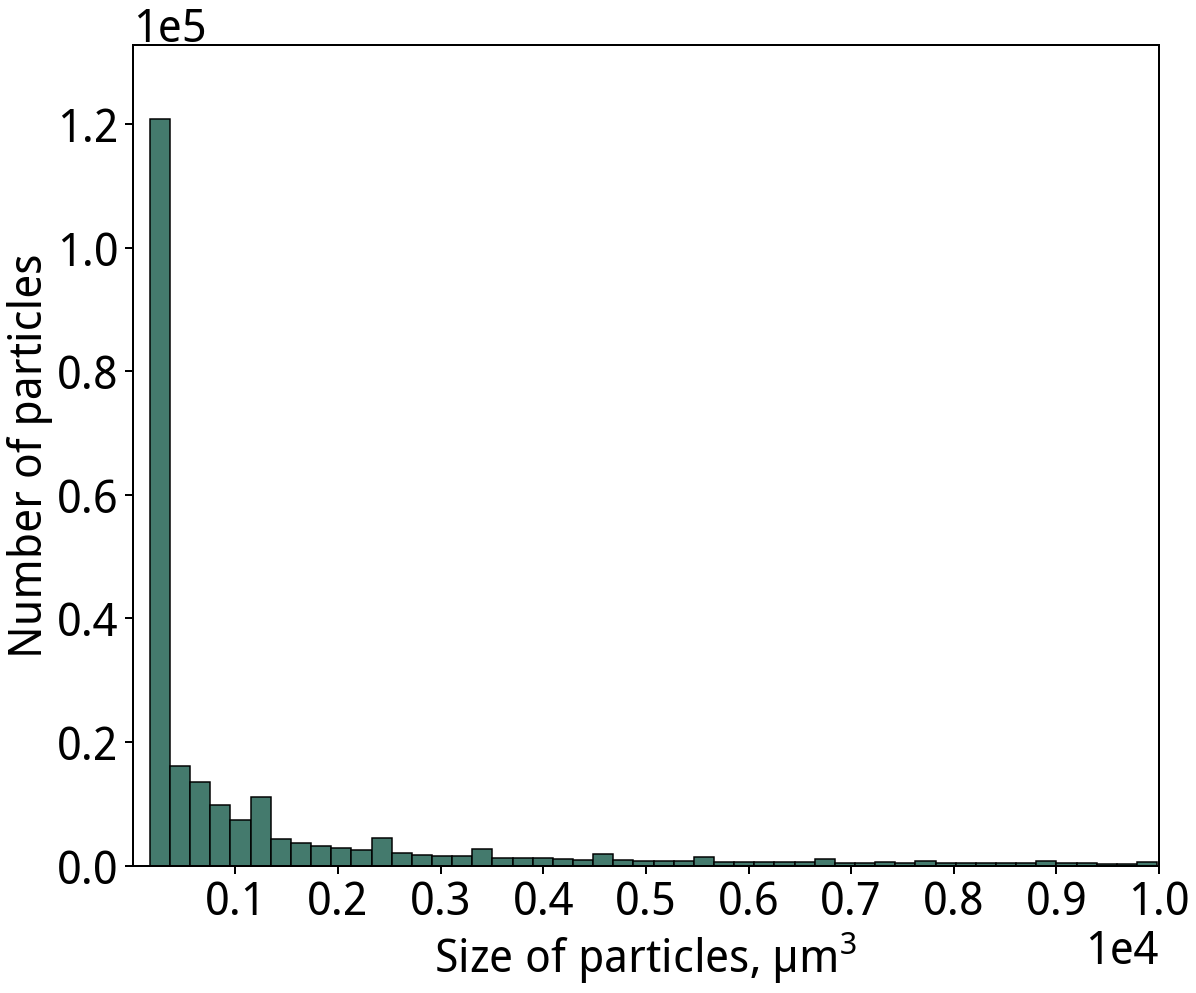

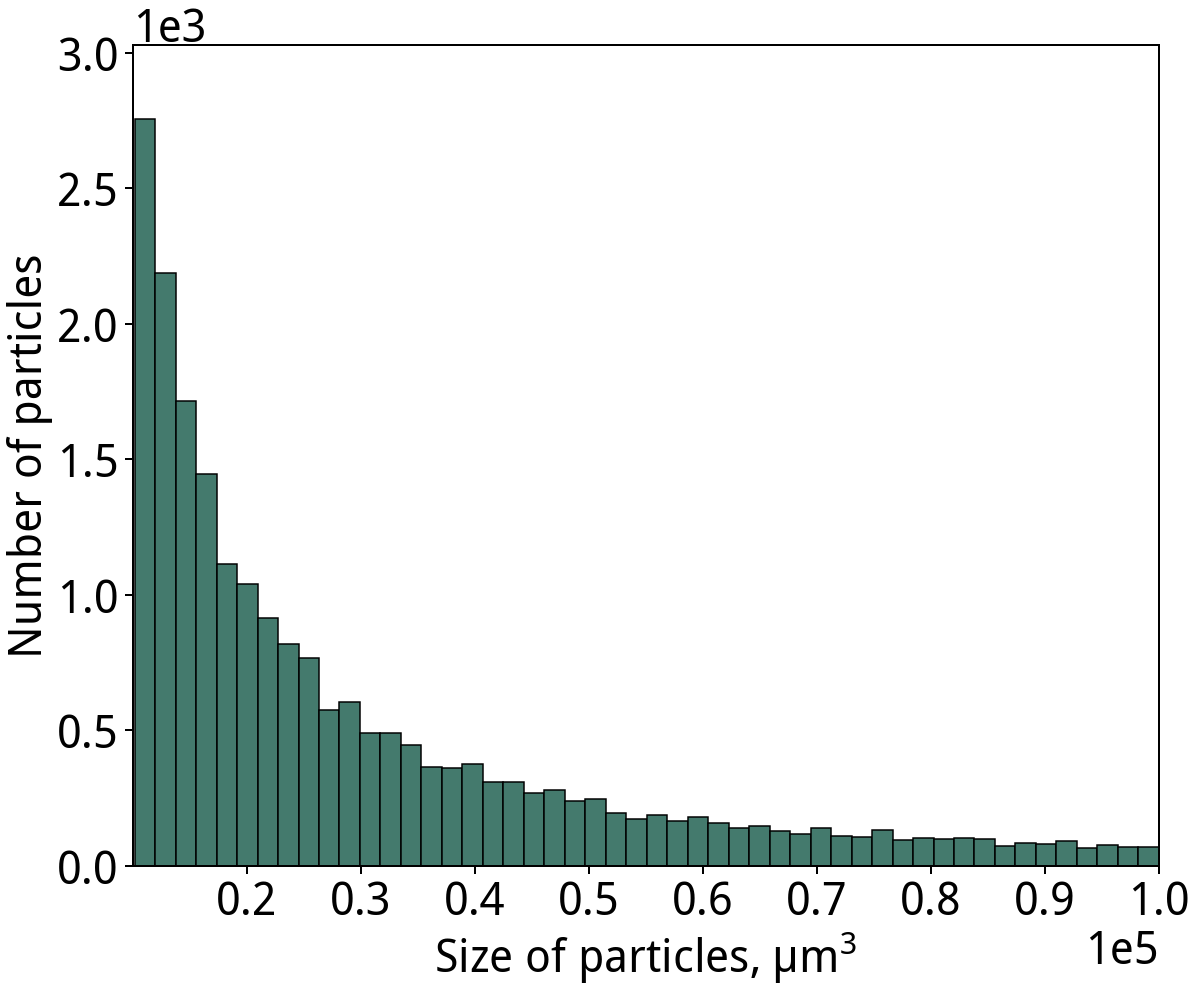

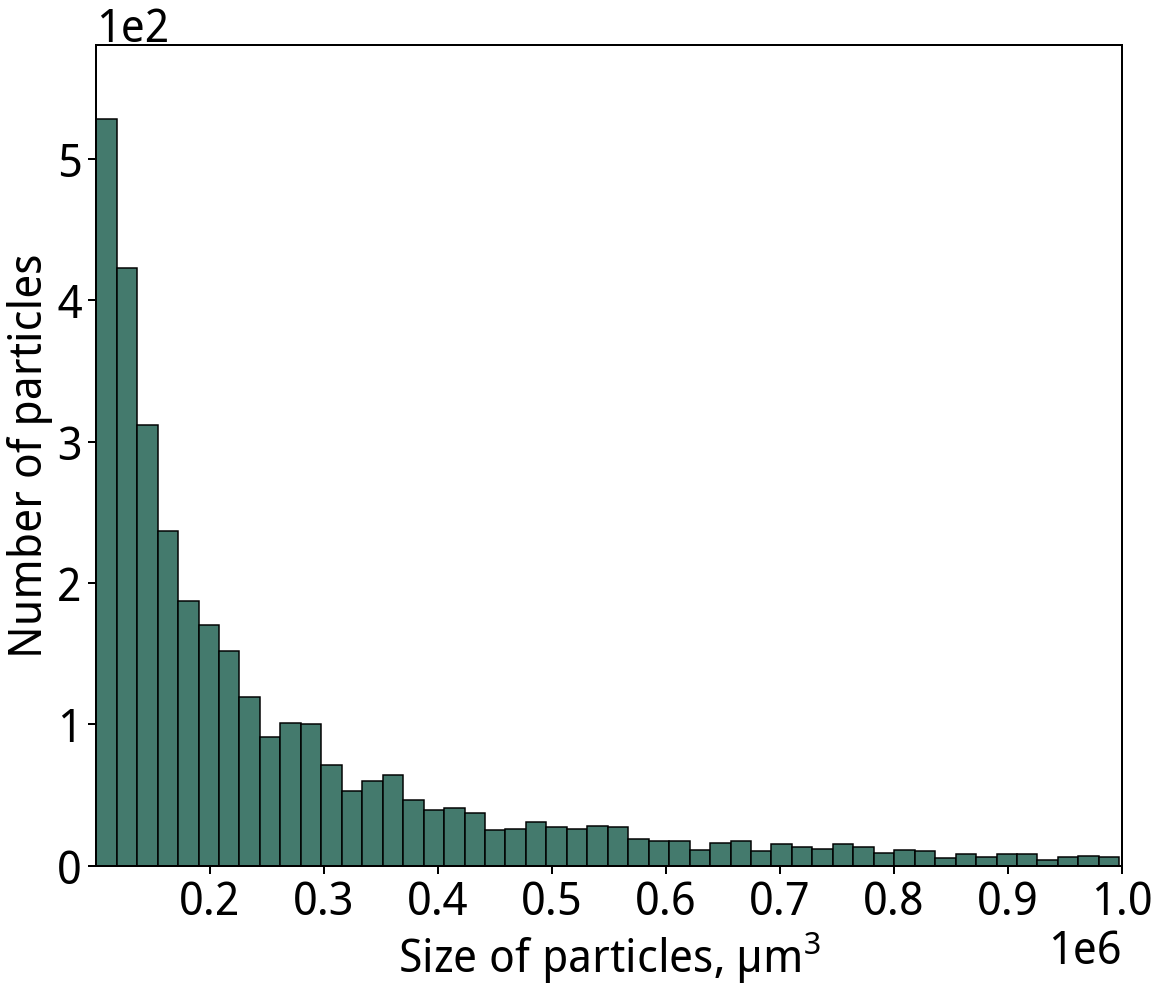

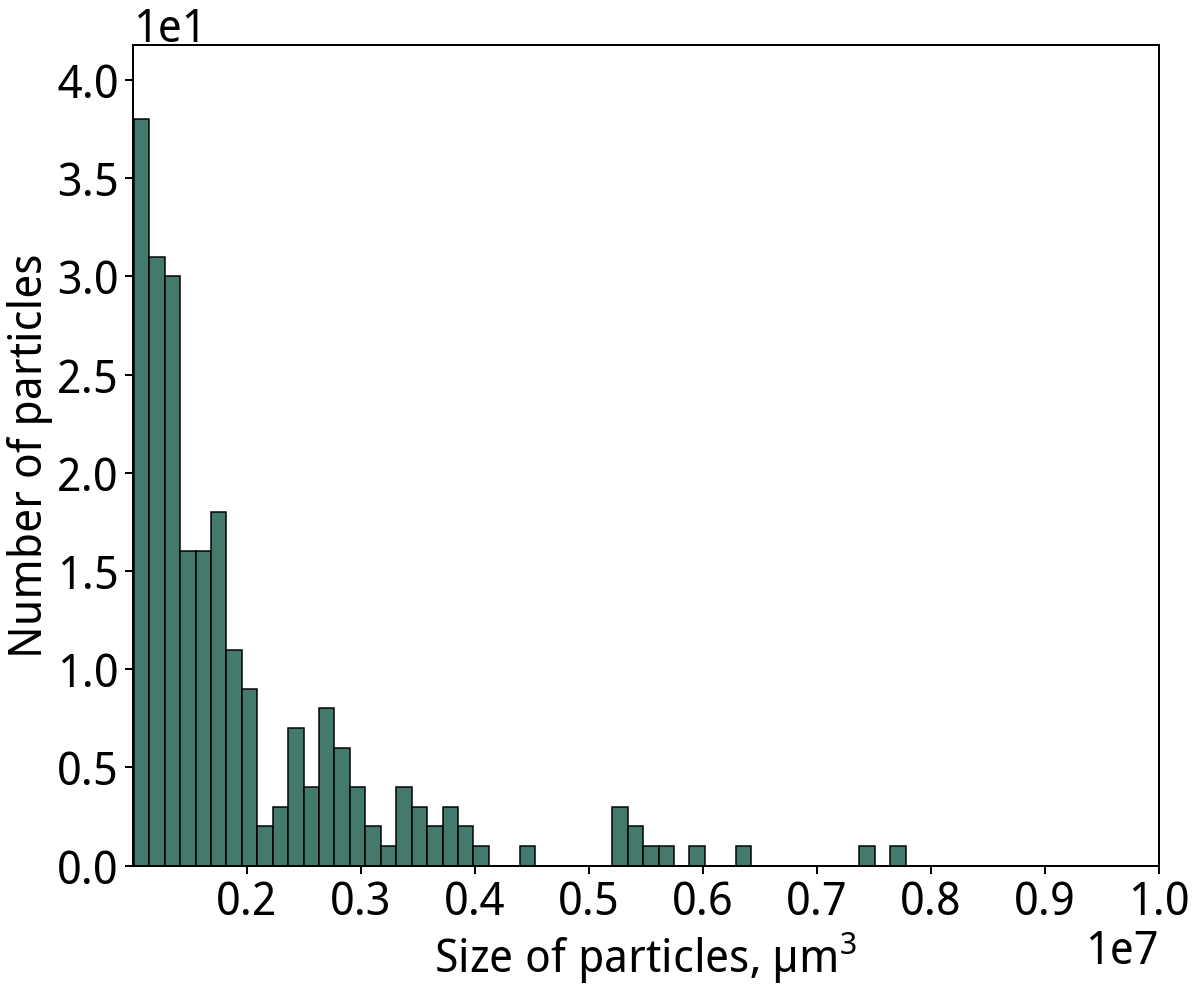

In [75]:
plot_barchart('./data/bioglass_results/', 
              './data/bioglass_results/', 
              'Zd_40fps_Silicon',
               [(1,10000000), (1,10000), (10000,100000), (100000,1000000), (1000000,10000000)],
              'green')

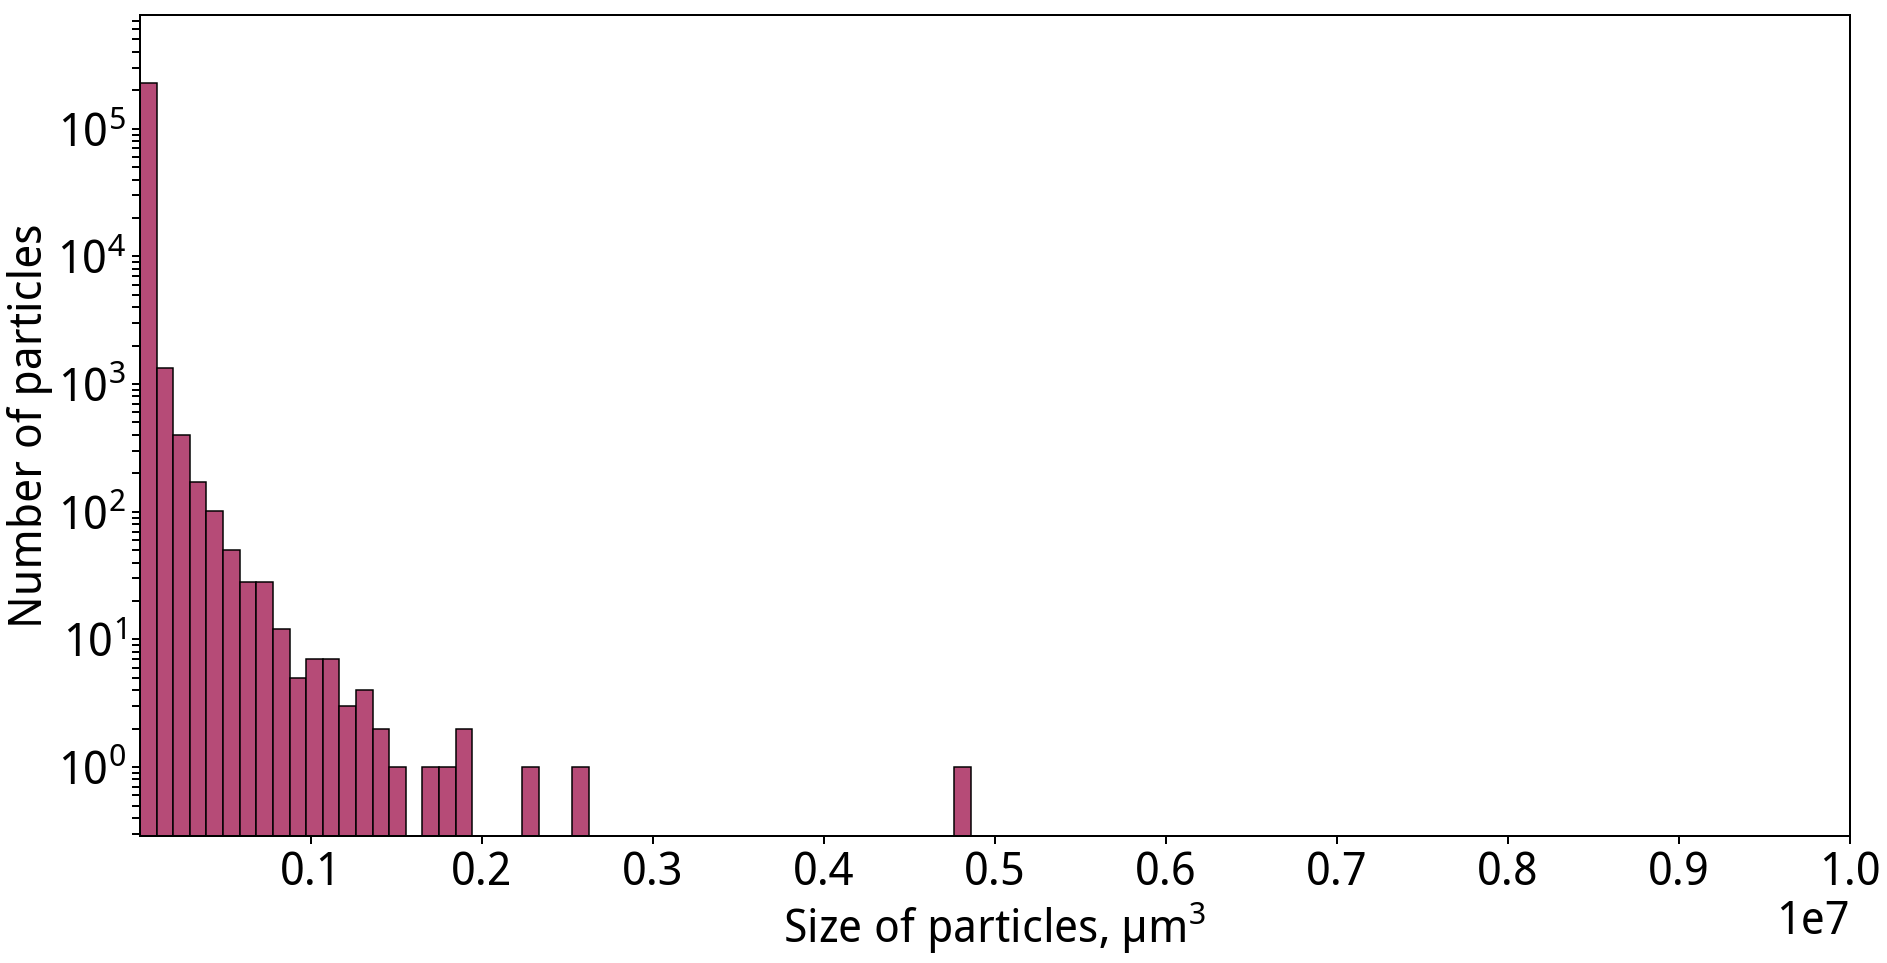

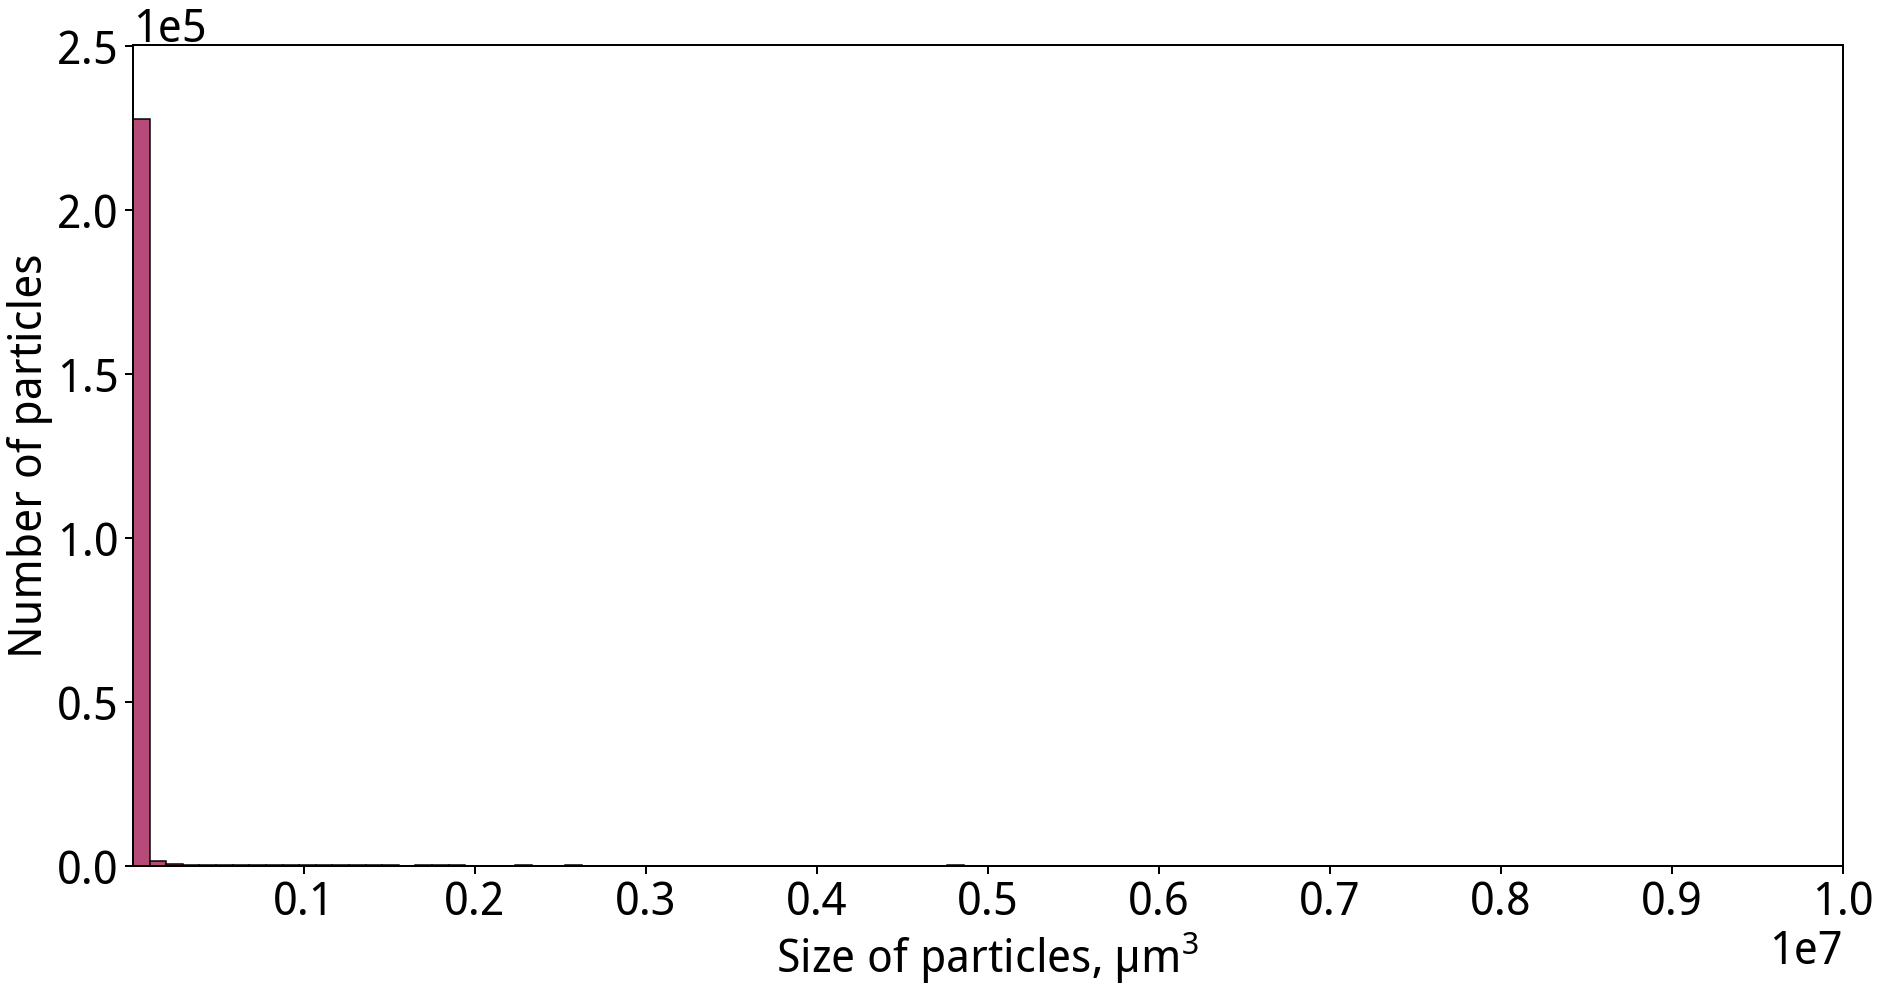

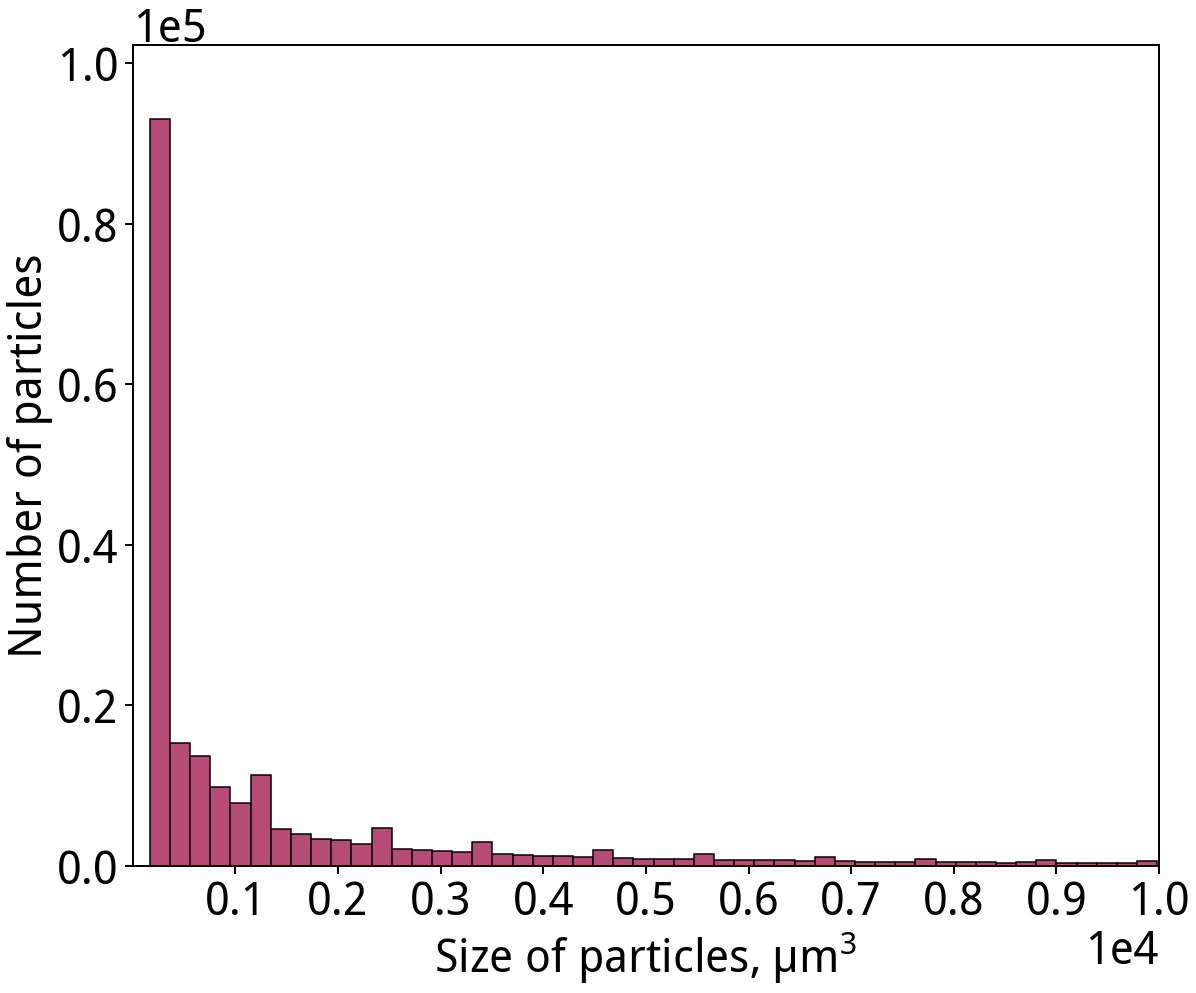

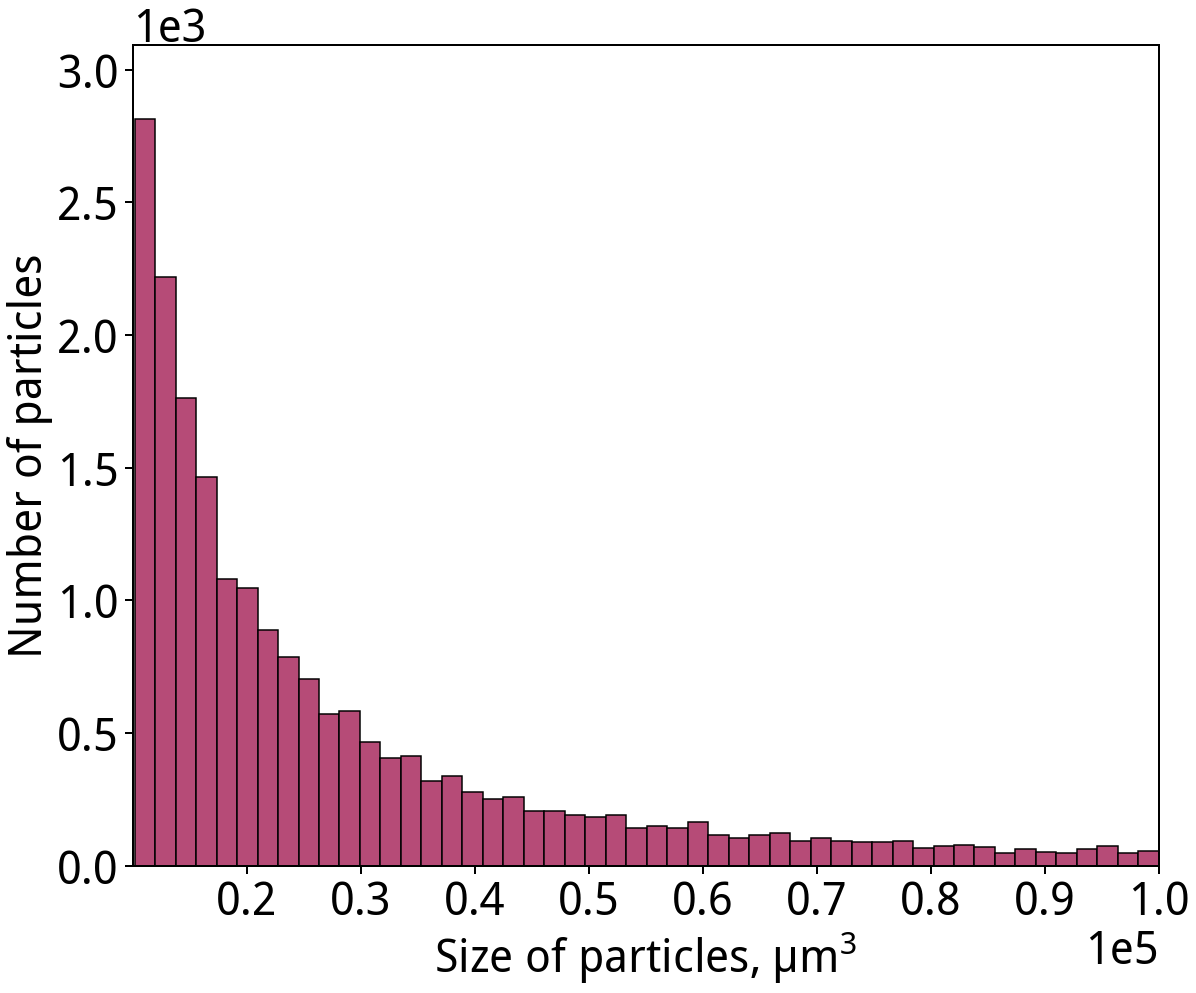

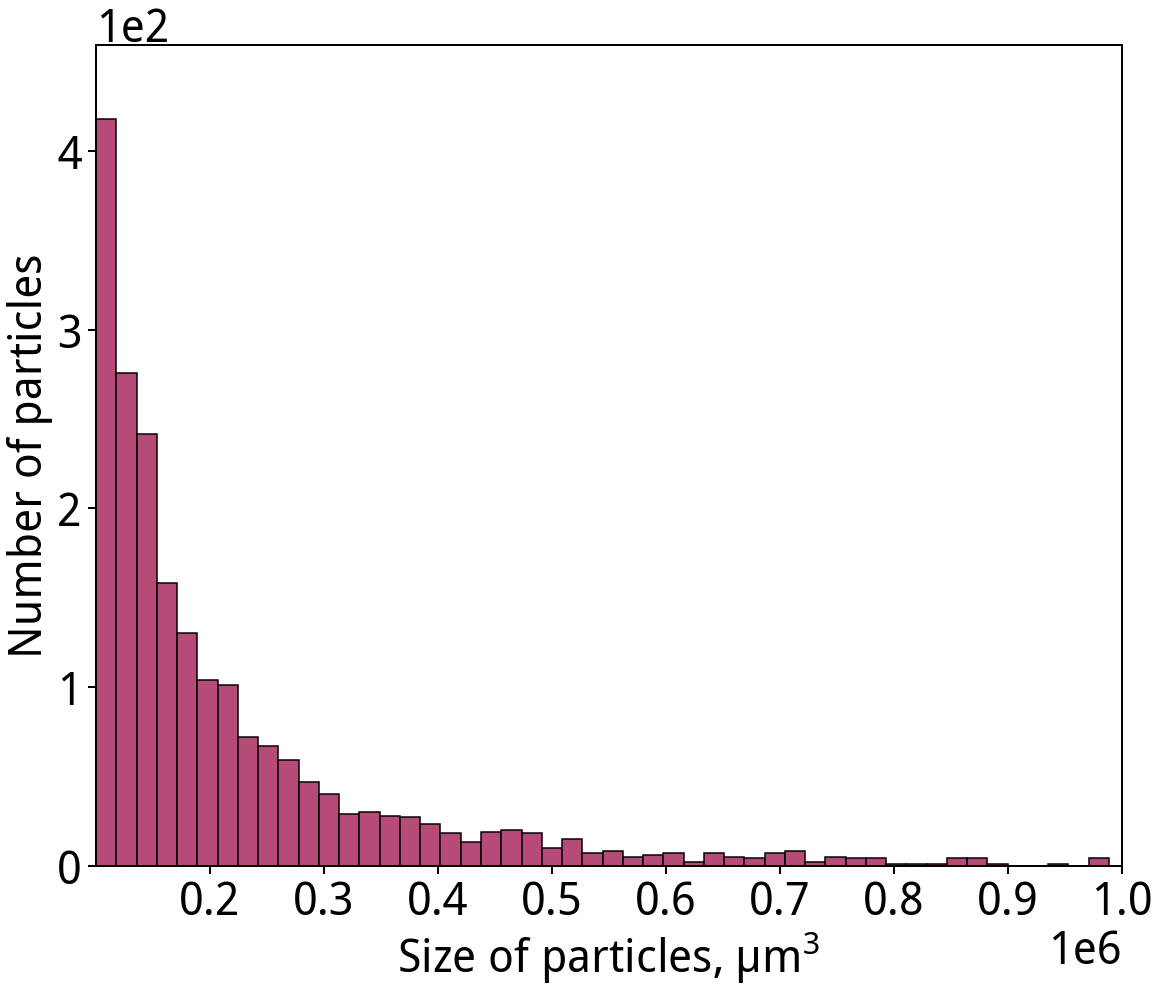

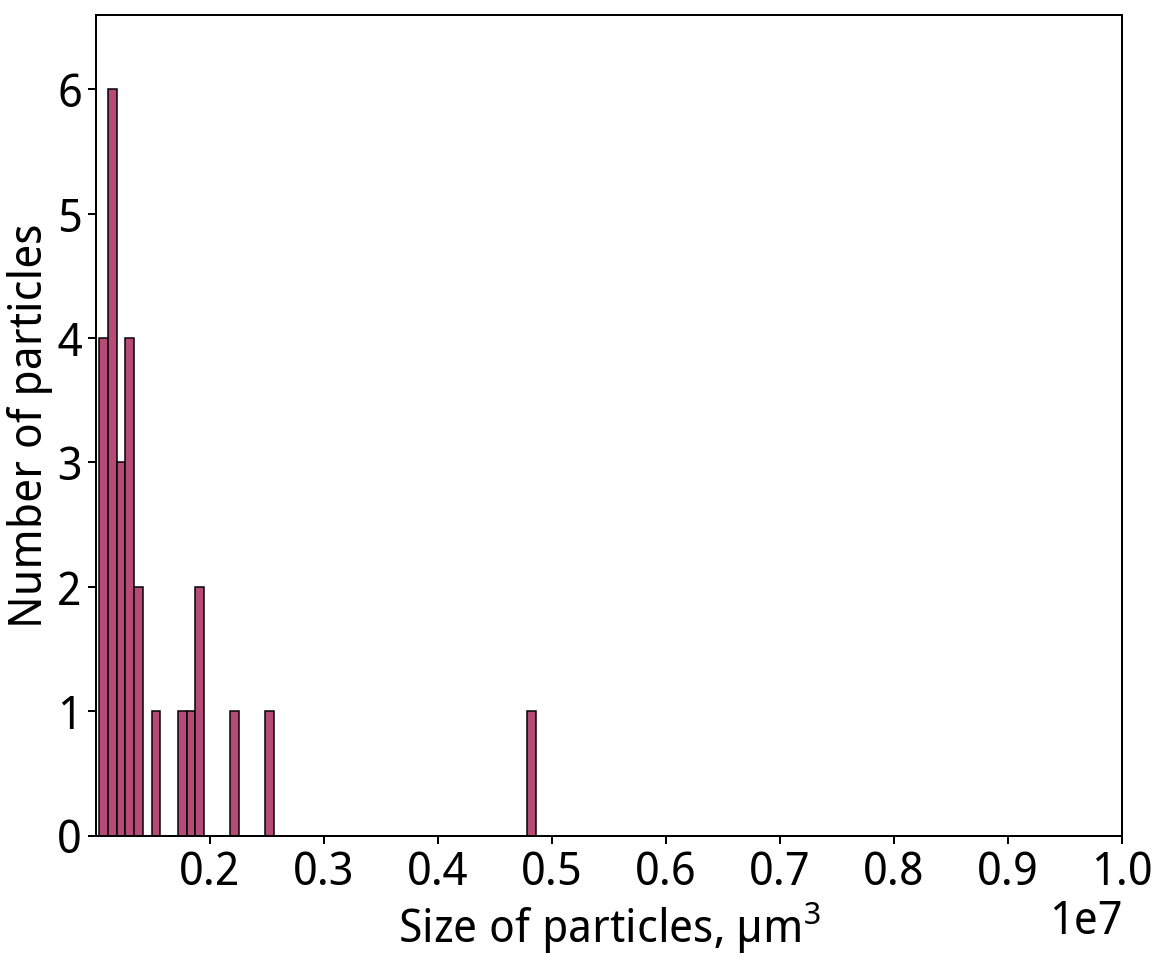

In [71]:
plot_barchart('./data/bioglass_results/', 
              './data/bioglass_results/', 
              'Zn_40fps_Silicon',
               [(1,10000000), (1,10000), (10000,100000), (100000,1000000), (1000000,10000000)],
              'red')

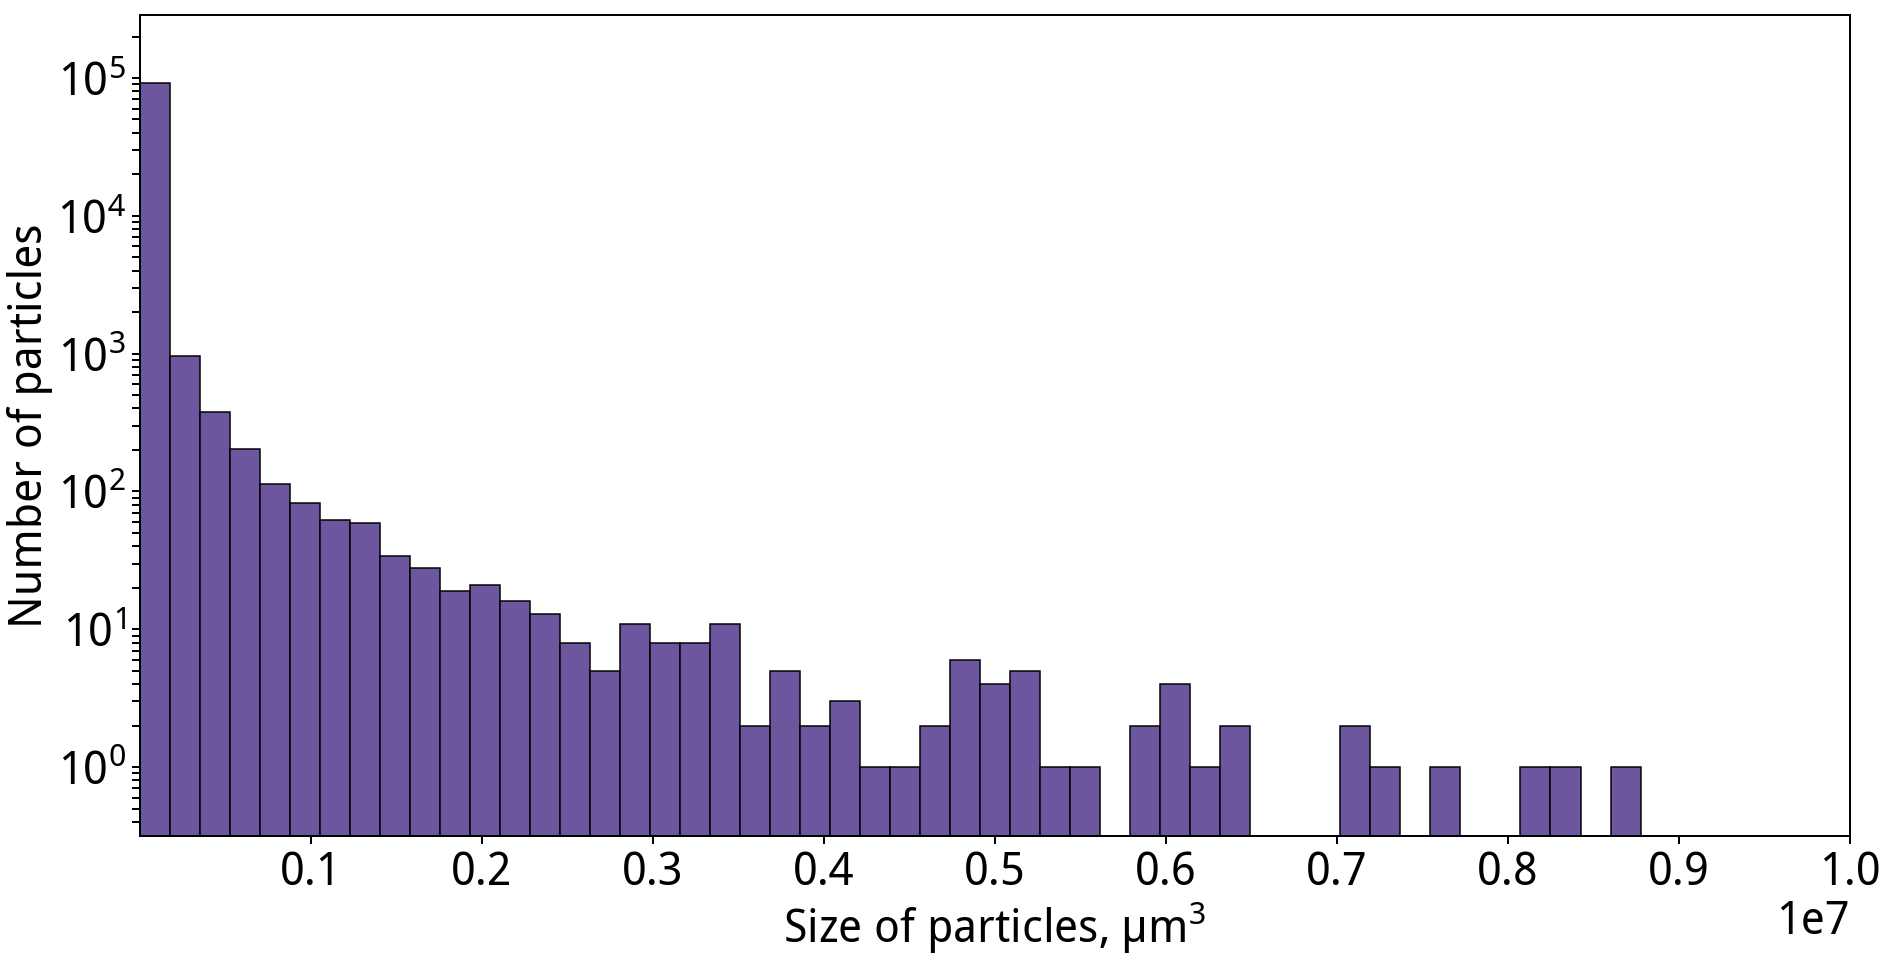

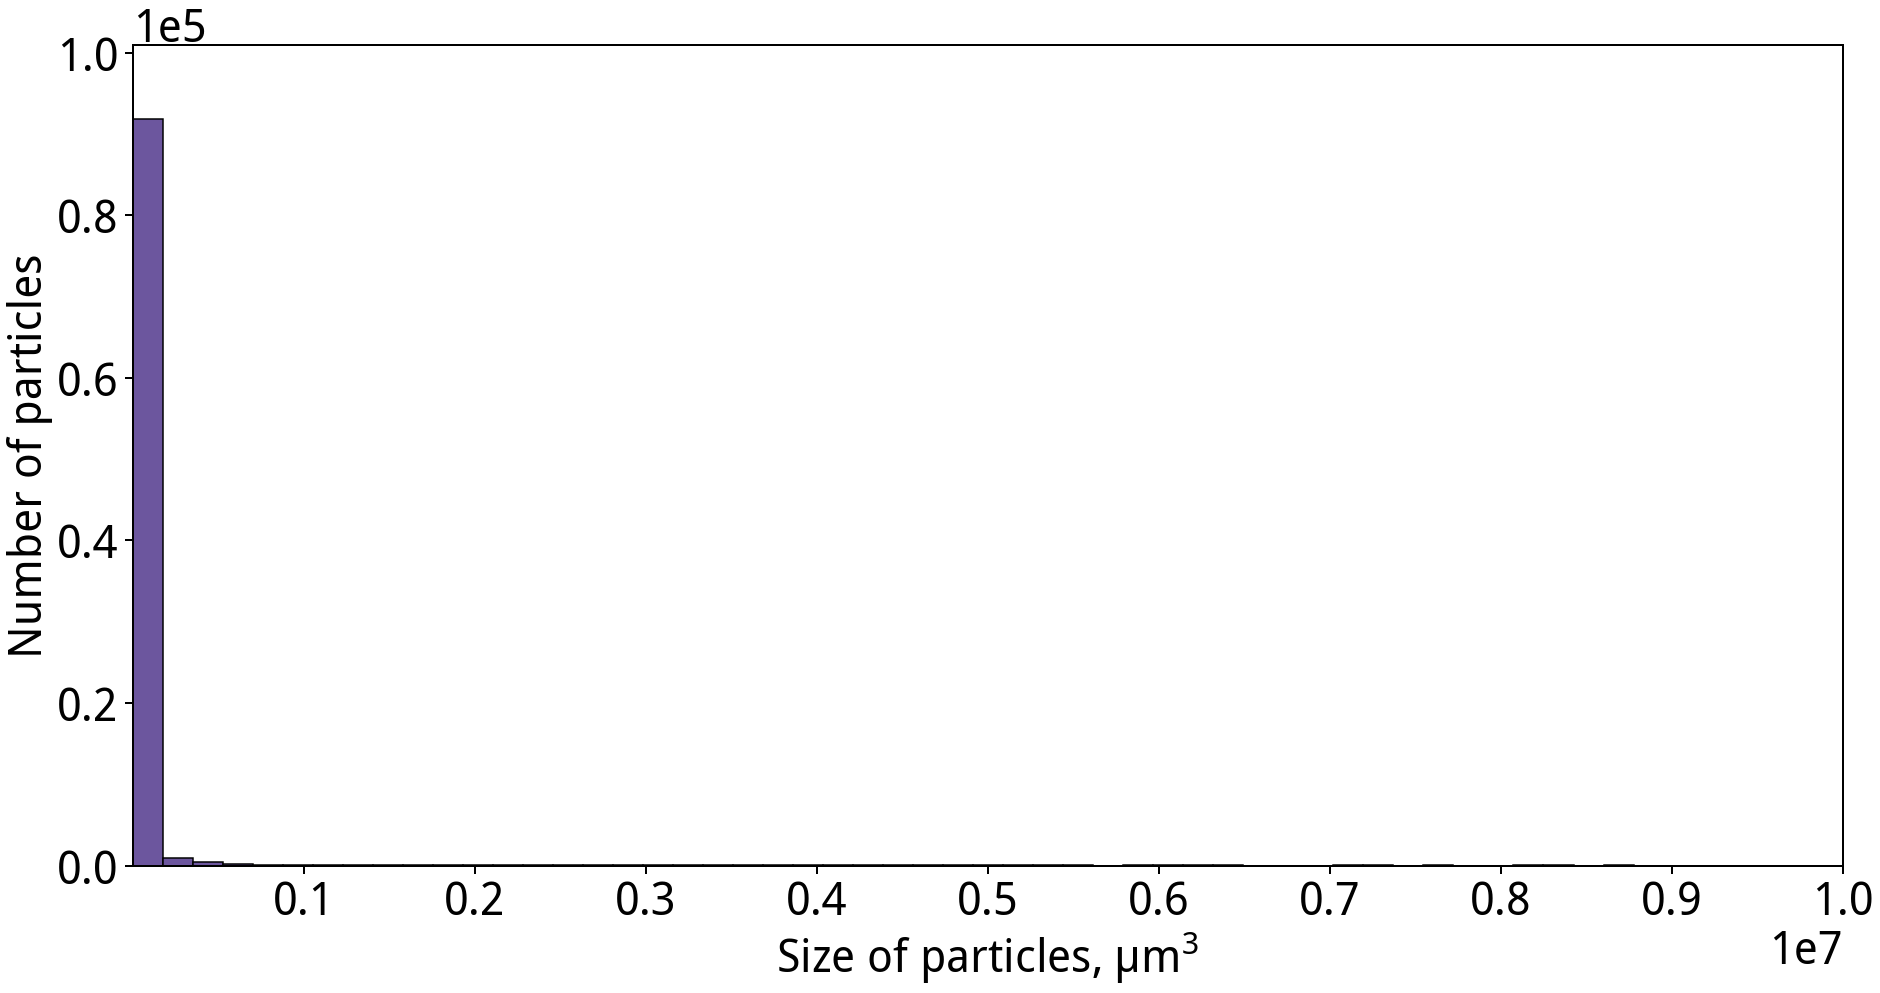

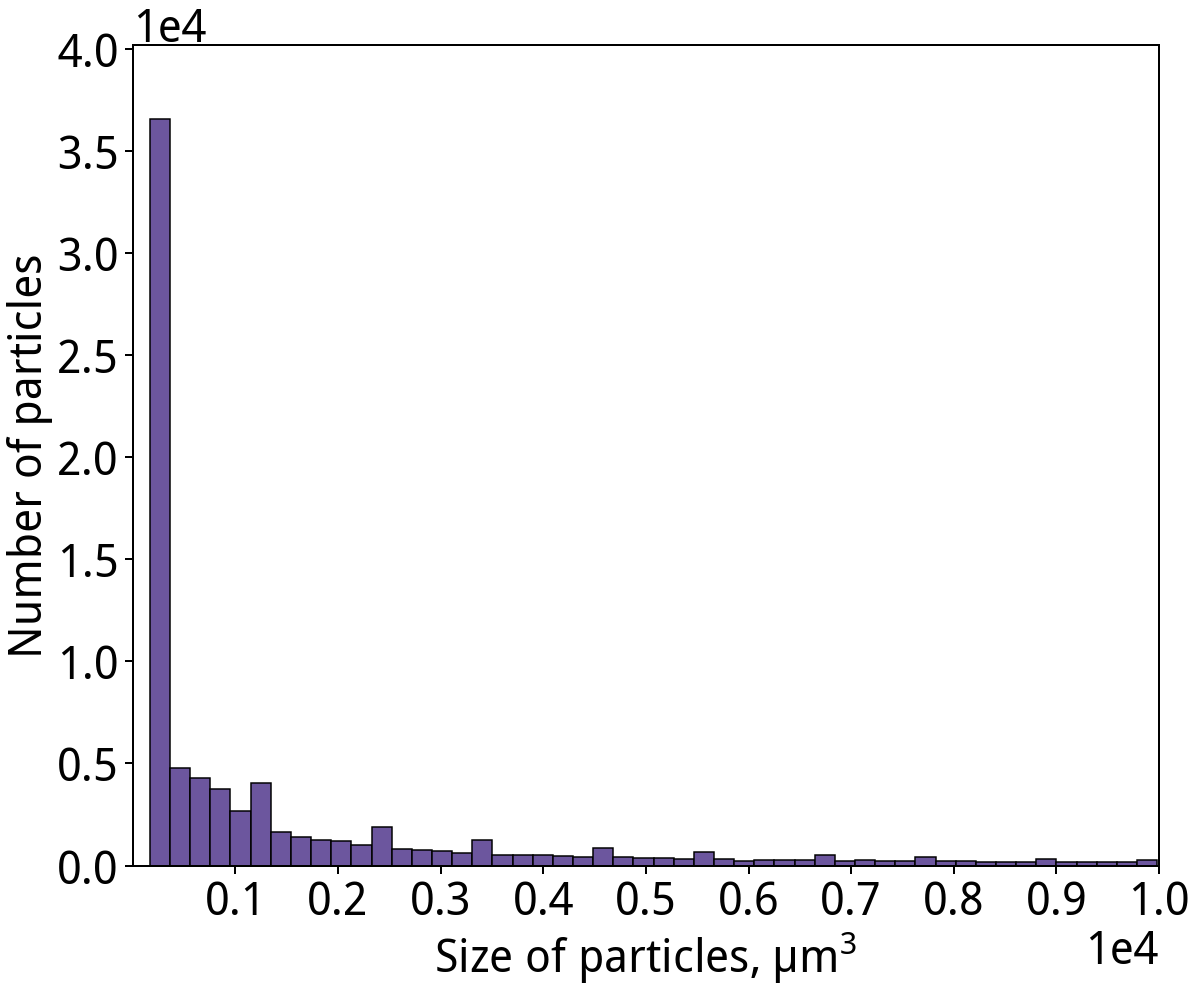

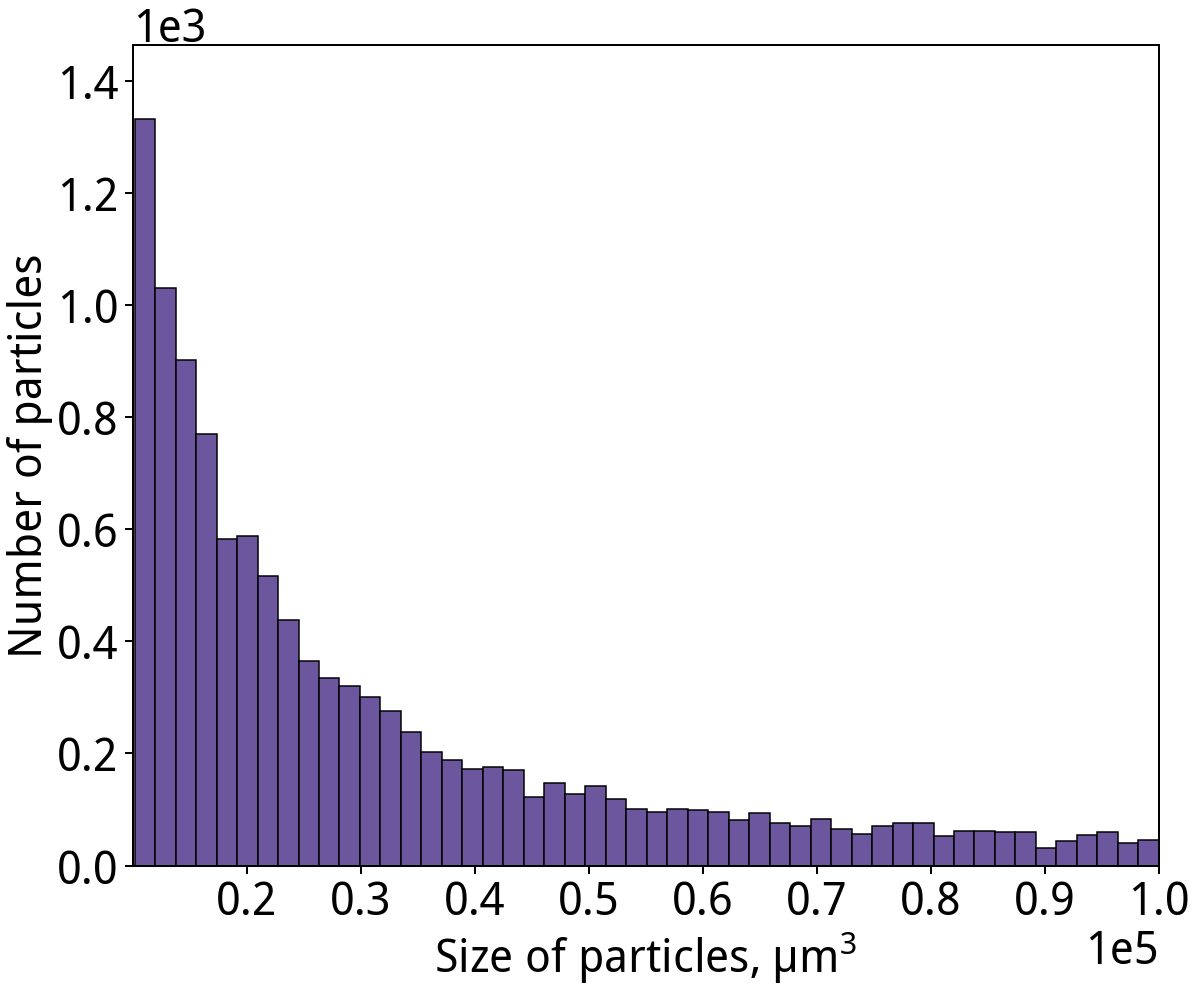

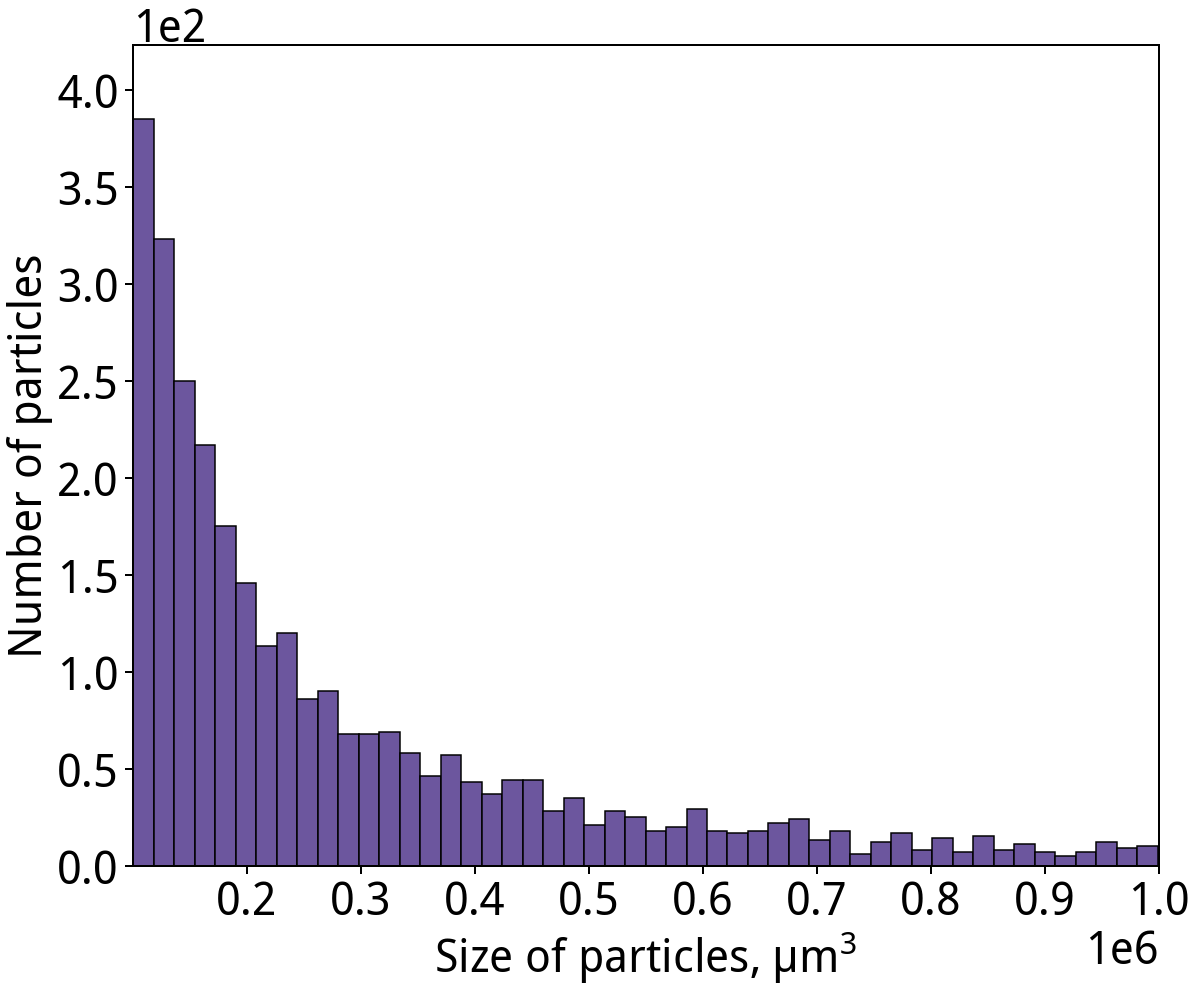

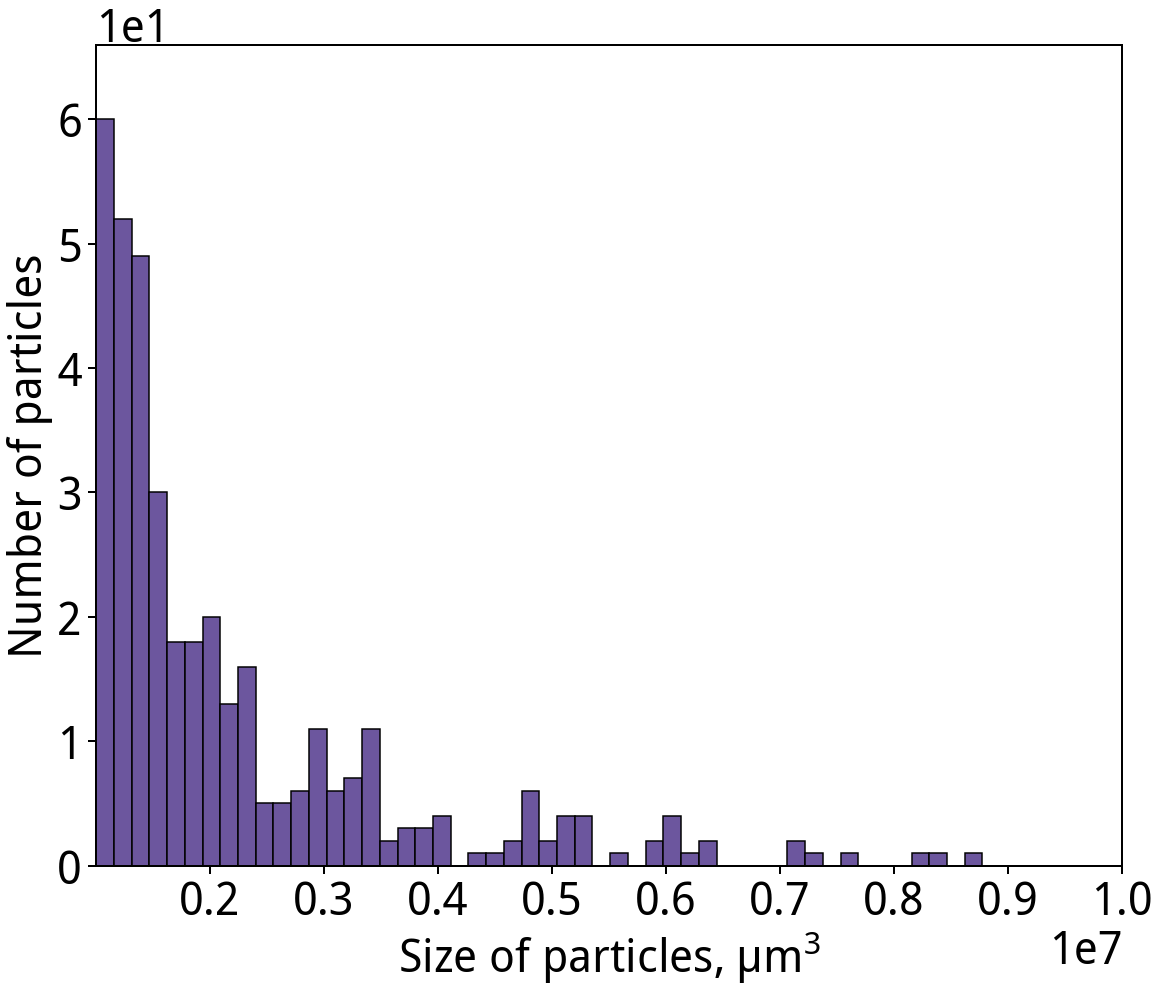

In [72]:
plot_barchart('./data/bioglass_results/', 
              './data/bioglass_results/', 
              'Sn_40fps_Silicon',
               [(1,10000000), (1,10000), (10000,100000), (100000,1000000), (1000000,10000000)],
              'violet')

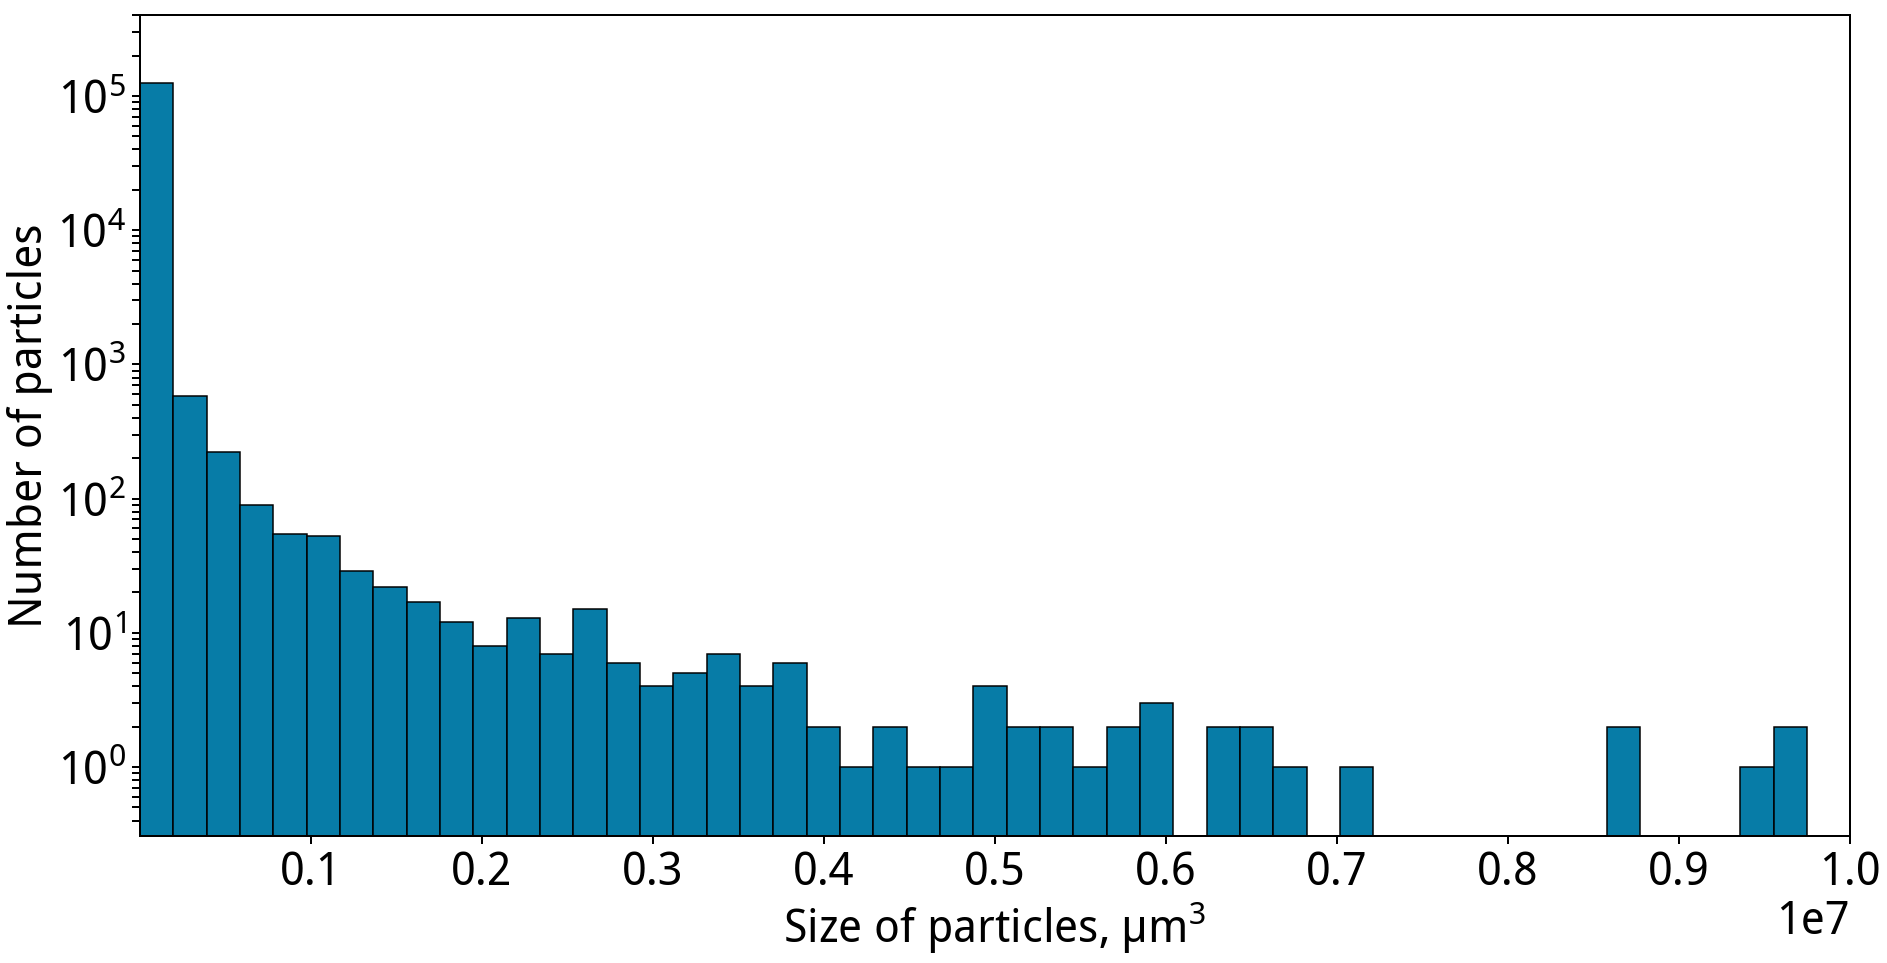

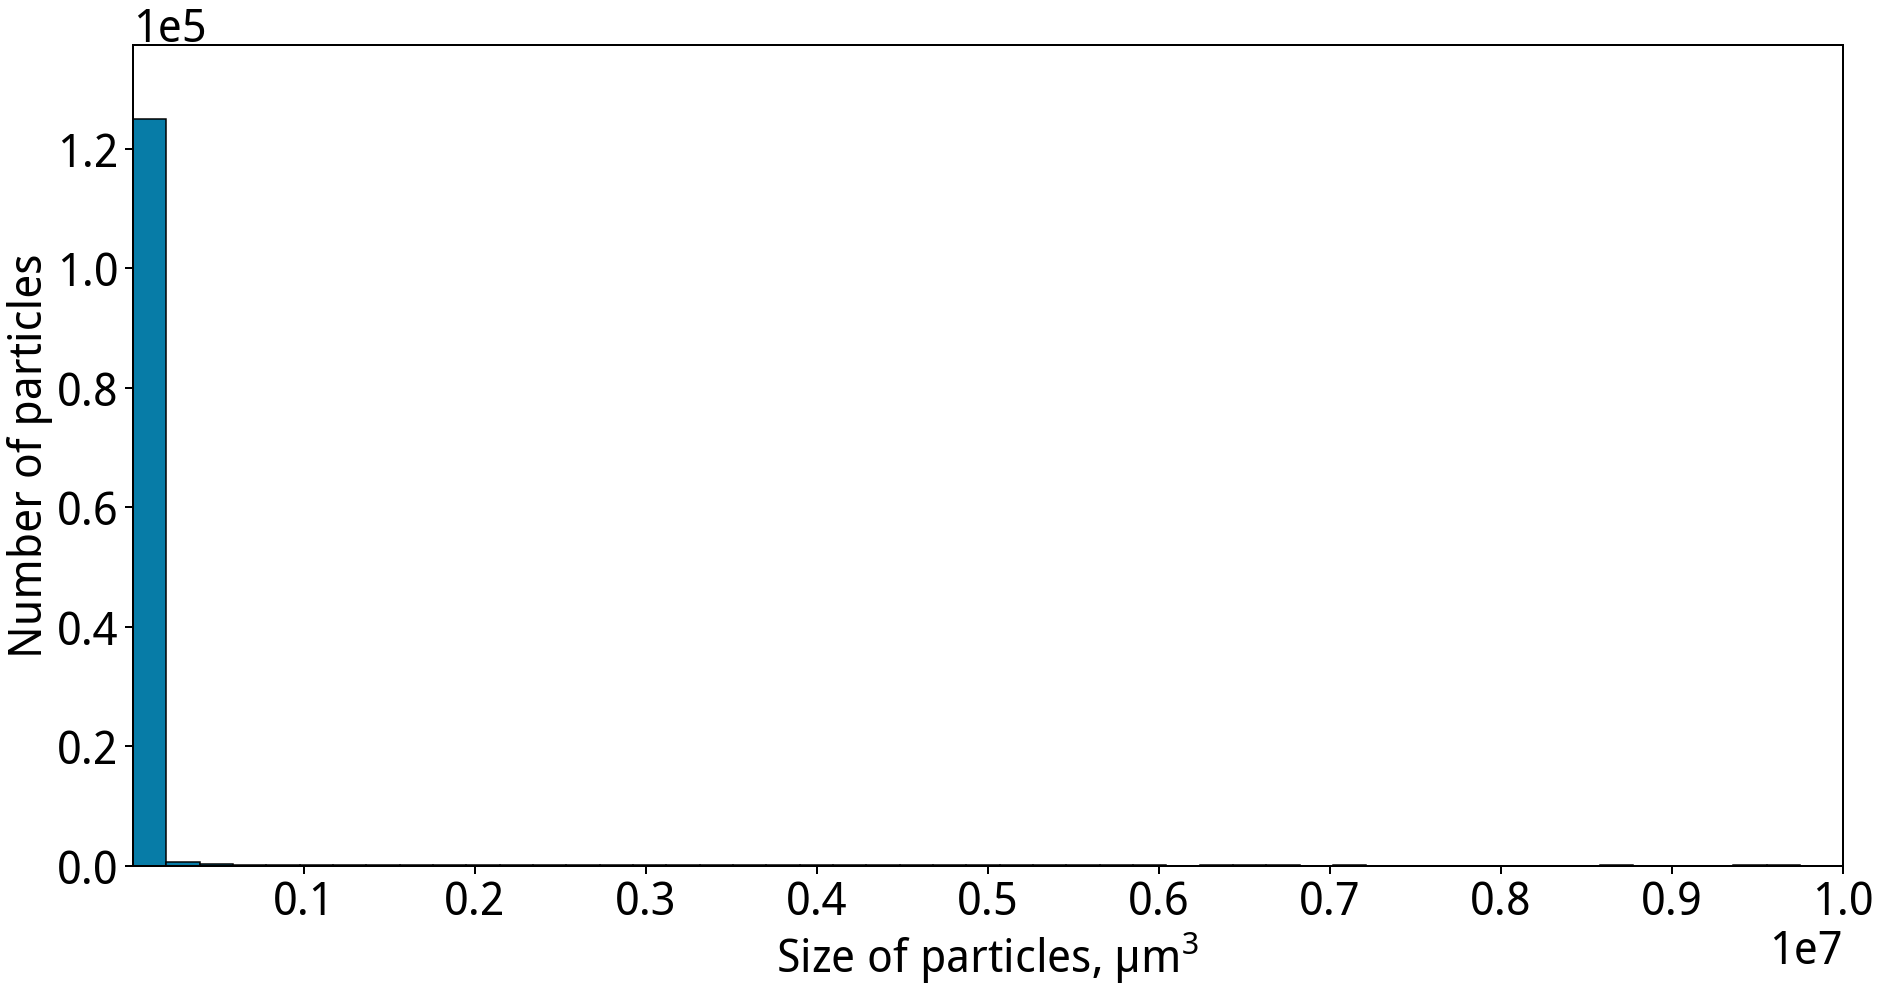

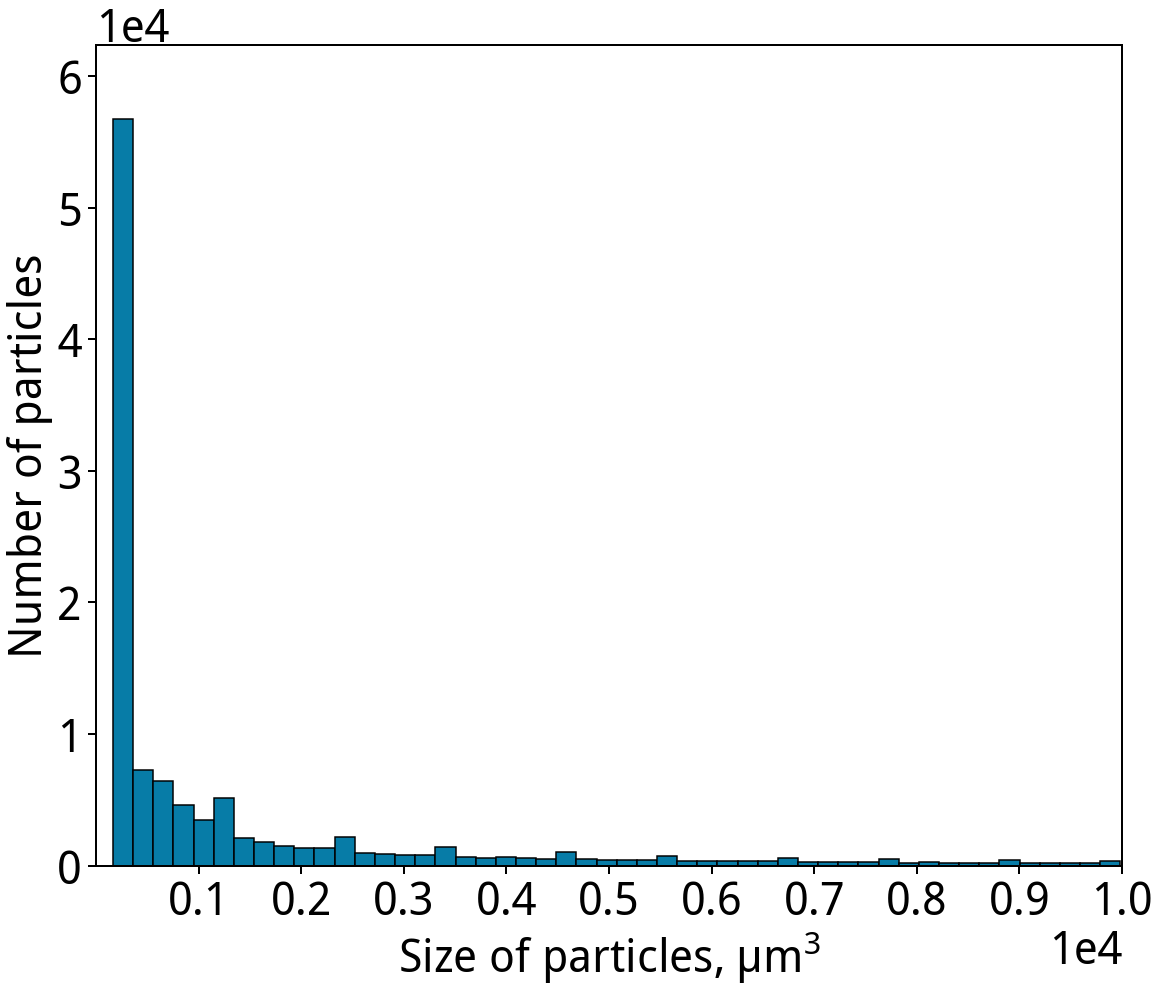

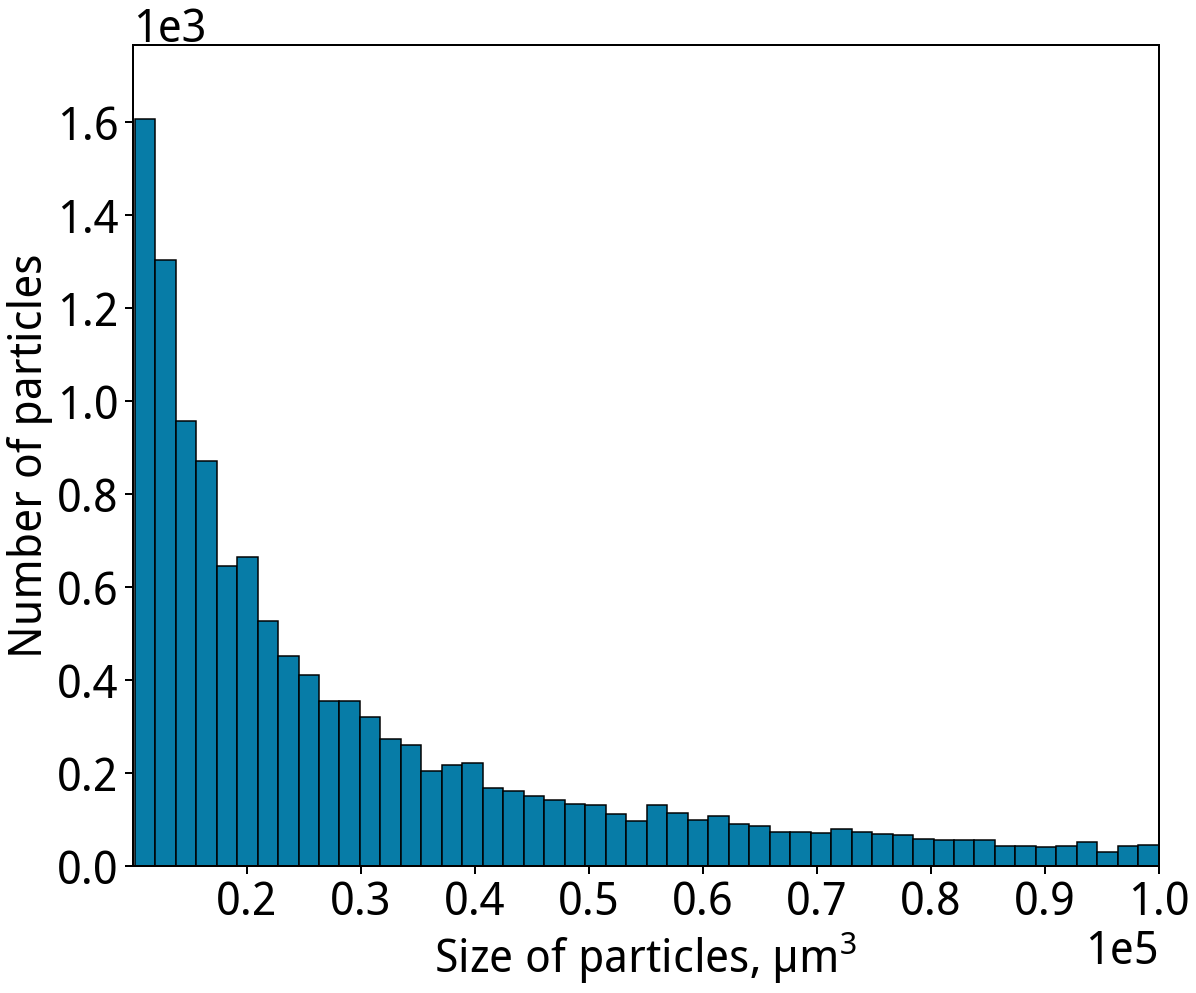

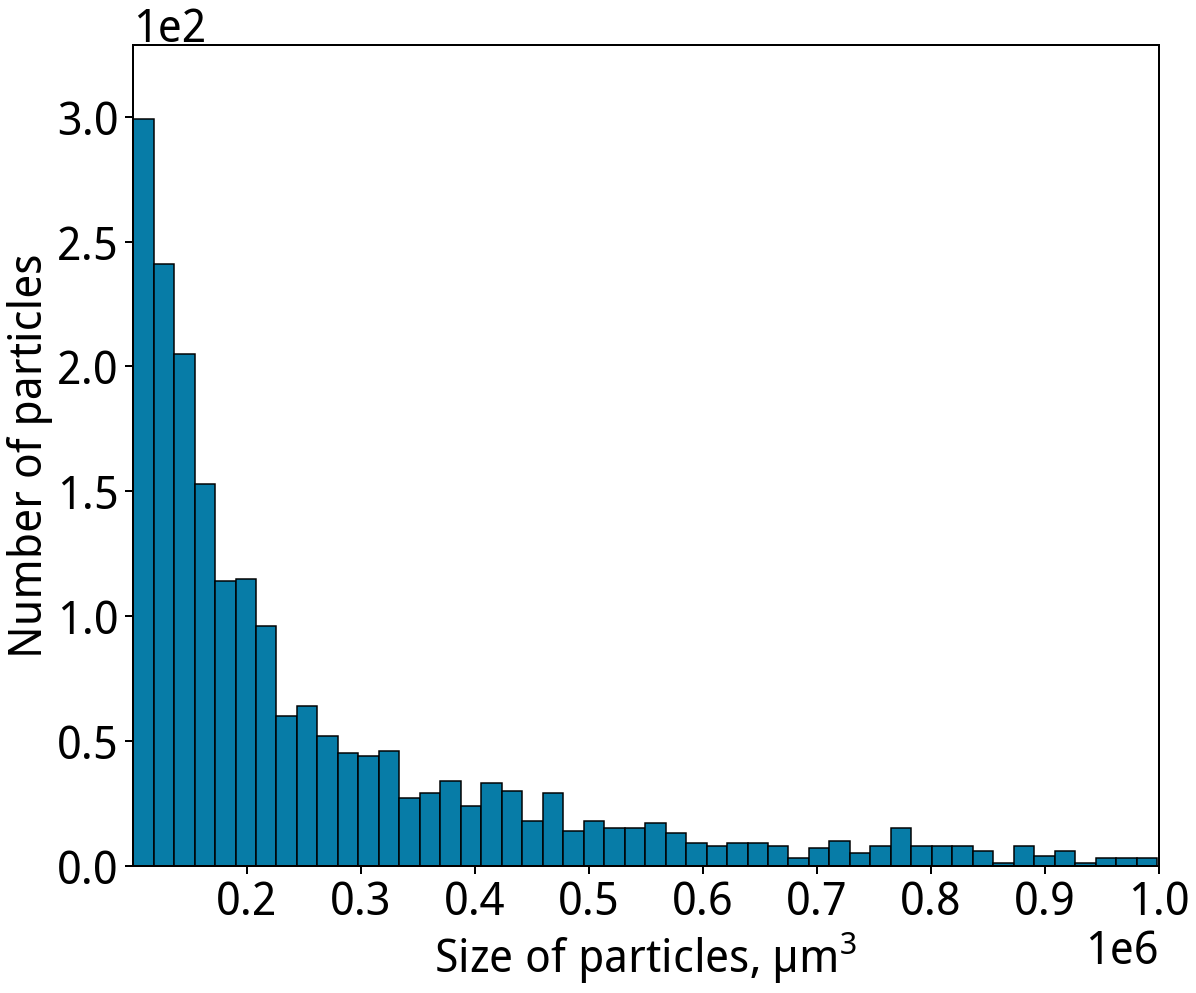

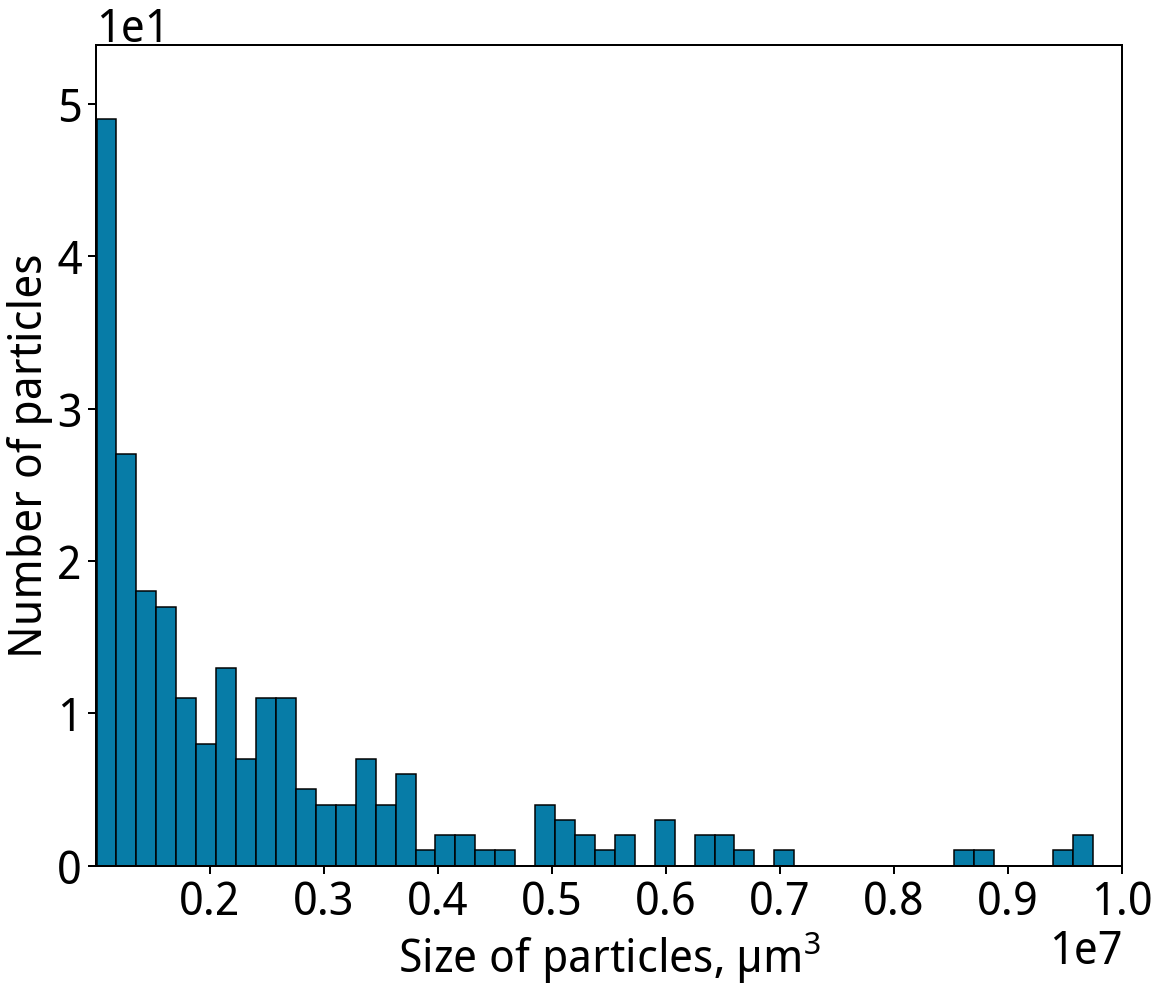

In [73]:
plot_barchart('./data/bioglass_results/', 
              './data/bioglass_results/', 
              'Mg_40fps_Silicon',
               [(1,10000000), (1,10000), (10000,100000), (100000,1000000), (1000000,10000000)],
              'blue')